In [1]:
# Core data processing libraries
import polars as pl
import pandas as pd
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Path and file handling
from pathlib import Path
import glob
import os
import sys

# Configure plotting
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

# Display options for better output
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 50)

# Add project root to Python path for module imports
current_dir = Path.cwd()
project_root = current_dir.parent if current_dir.name == "notebooks" else current_dir
sys.path.insert(0, str(project_root))

from src.config import DATA_PATH, PROCESSED_DATA_PATH, MODELS_PATH

# 1. Read data

In [2]:
# Define data directory
data_dir = Path(os.path.join(DATA_PATH, "le_boncoin_13_oct_2025"))
# Find all CSV files
csv_files = list(data_dir.glob("*.csv"))

dataframes = {}
total_rows = 0

for file_path in csv_files:

    df = pl.read_csv(
        file_path,
        infer_schema_length=0,
        #encoding="utf8",
    )
    
    dataframes[file_path.stem] = df
    rows = df.height
    cols = df.width
    total_rows += rows
    
    print(f"{file_path.name}: {rows:,} rows × {cols} columns")
        

DELAGE.csv: 4 rows × 35 columns
GENERAL MOTORS.csv: 71 rows × 35 columns
AUSTIN.csv: 282 rows × 35 columns
PIAGGIO.csv: 18 rows × 35 columns
MERCURY.csv: 18 rows × 35 columns
LINCOLN.csv: 39 rows × 35 columns
TRABANT.csv: 5 rows × 35 columns
DAF.csv: 8 rows × 35 columns
LAMBORGHINI.csv: 278 rows × 35 columns
BERTONE.csv: 6 rows × 35 columns
DACIA.csv: 18,670 rows × 35 columns
SUZUKI.csv: 4,668 rows × 35 columns
CASALINI.csv: 79 rows × 35 columns
OPEL.csv: 19,869 rows × 35 columns
LEAPMOTOR.csv: 146 rows × 35 columns
GENESIS.csv: 2 rows × 35 columns
ALFA ROMEO.csv: 4,539 rows × 35 columns
BYD.csv: 434 rows × 35 columns
PORSCHE.csv: 10,838 rows × 35 columns
MORGAN.csv: 143 rows × 35 columns
KIA.csv: 10,345 rows × 35 columns
BMW.csv: 48,326 rows × 35 columns
UMM.csv: 4 rows × 35 columns
HUMMER.csv: 92 rows × 35 columns
SILENCE.csv: 3 rows × 35 columns
HONGQI.csv: 1 rows × 35 columns
NISSAN.csv: 16,208 rows × 35 columns
BELLIER.csv: 25 rows × 35 columns
INFINITI.csv: 296 rows × 35 columns


In [3]:
df = pl.concat(dataframes.values(), how="vertical")

print(df.shape)
df.head(3)

(732427, 35)


url,first_publication_date,index_date,price,marque,modele,annee_modele,kilometrage,energie,boite_de_vitesse,nombre_de_portes,nombre_de_place_s,version_constructeur,date_de_premiere_mise_en_circulation,type_de_vehicule,couleur,crit_air,puissance_fiscale,puissance_din,permis,reference,duree_de_disponibilite_des_pieces_detachees,pays,id_region,region,id_departement,departement,ville_affichee,ville,code_postal,latitude,longitude,source,fournisseur,forme_existante
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""https://www.leboncoin.fr/ad/vo…","""2025-09-01 15:37:26""","""2025-10-08 18:28:10""","""24900 €""","""DELAGE""","""D4""","""1960""","""15000 km""","""Essence""","""Manuelle""","""4""","""4""",null,"""01/1935""","""Berline""","""Beige""",null,"""8 Cv""",null,"""Avec permis""",null,null,"""FR""","""3""","""Auvergne""","""63""","""Puy-de-Dôme""","""Romagnat 63540 Opme""","""Romagnat""","""63540""","""45.70758""","""3.08908""","""city""","""here""","""True"""
"""https://www.leboncoin.fr/ad/vo…","""2025-10-06 19:02:42""","""2025-10-06 19:02:42""","""39000 €""","""DELAGE""","""DI""","""1960""","""43000 km""","""Essence""","""Manuelle""","""4""","""6""",null,"""01/1924""","""Cabriolet""",null,null,"""11 Cv""","""35 Ch""","""Avec permis""",null,null,"""FR""","""17""","""Nord-Pas-de-Calais""","""62""","""Pas-de-Calais""","""La Couture 62136""","""La Couture""","""62136""","""50.58426""","""2.70473""","""city""","""here""","""True"""
"""https://www.leboncoin.fr/ad/vo…","""2025-09-30 20:16:40""","""2025-09-30 20:16:40""","""18000 €""","""DELAGE""","""DI""","""1960""","""120000 km""","""Essence""","""Manuelle""","""4""","""5""",null,"""01/1936""","""Berline""","""Bleu""",null,"""12 Cv""","""80 Ch""","""Avec permis""",null,null,"""FR""","""17""","""Nord-Pas-de-Calais""","""59""","""Nord""","""Rousies 59131""","""Rousies""","""59131""","""50.27274""","""4.00581""","""city""","""here""","""True"""


In [4]:
# identify how many brands and cars we loose by removing brands with less than 1000 ads
brand_counts = df.group_by("marque").len().sort("len", descending=True).to_pandas()
cars_before = brand_counts["len"].sum()
brands_to_remove = brand_counts[brand_counts["len"] < 1000]
brands_remain = brand_counts[brand_counts["len"] >= 1000]
cars_after = brands_to_remove["len"].sum()

print(f"🚗 Cars before removal: {cars_before:,}")
print(f"🚗 Cars after removal: {cars_after:,}")
print(f"🔧 Brands removed: {len(brands_to_remove)}")
print(f"🔧 Brands remaining: {len(brands_remain)}")

🚗 Cars before removal: 732,427
🚗 Cars after removal: 12,946
🔧 Brands removed: 108
🔧 Brands remaining: 38


# 2. Detailed Data Cleaning and Outlier Analysis

## Step 1: Define Variables
Define the key variables for our car price prediction analysis.

In [5]:
# Define the key variables for our car price prediction analysis
TARGET_VAR = 'price'
FEATURE_VARS = ['marque', 'modele', 'annee_modele', 'kilometrage']
MODEL_VARS = [TARGET_VAR] + FEATURE_VARS

## Step 2: Data Type Conversion and Cleaning

Create clean, numeric versions of price, year, and kilometers columns, then create a simplified DataFrame for analysis.

In [6]:
print("🔧 DATA TYPE CONVERSION AND CLEANING")
print("=" * 50)

# Show original data types and sample values
print("Original data types and samples:")
for var in MODEL_VARS:
    if var in df.columns:
        print(f"  {var}: {df[var].dtype}")
        sample_vals = df[var].head(5).to_list()
        print(f"    Sample values: {sample_vals}")

print("\n" + "="*50)
print("CLEANING PROCESS:")
print("="*50)

# Clean price column
print("\n1. Cleaning PRICE column...")
df_clean = df.with_columns(
    pl.when(pl.col('price').str.replace_all(r'[^\d.]', '') == "")
        .then(None)
        .otherwise(pl.col('price').str.replace_all(r'[^\d.]', ''))
        .cast(pl.Float64)
        .alias('price_numeric')
)

# Clean year and kilometers columns  
print("2. Cleaning YEAR and KILOMETERS columns...")
df_clean = df_clean.with_columns([
    pl.col("annee_modele").cast(pl.Float64, strict=False).alias("year_numeric"),
    pl.col("kilometrage").str.replace_all(r"[, km]", "").cast(pl.Float64, strict=False).alias("km_numeric")
])

# Create simplified DataFrame with renamed columns
print("3. Creating simplified DataFrame...")
df_model = df_clean.select([
    pl.col('price_numeric').alias('price'),
    pl.col('year_numeric').alias('year'), 
    pl.col('km_numeric').alias('km'),
    pl.col('marque').alias('brand'),
    pl.col('modele').alias('model')
]).filter(
    # Keep only rows with valid price (our target variable)
    pl.col('price').is_not_null()
)

print(f"\n✅ CLEANING RESULTS:")
print(f"Original DataFrame: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"Cleaned DataFrame: {df_model.shape[0]:,} rows × {df_model.shape[1]} columns")
print(f"Rows removed due to invalid price: {df.shape[0] - df_model.shape[0]:,}")

# Show cleaned data types
print(f"\nCleaned data types:")
for col in df_model.columns:
    print(f"  {col}: {df_model[col].dtype}")

🔧 DATA TYPE CONVERSION AND CLEANING
Original data types and samples:
  price: String
    Sample values: ['24900 €', '39000 €', '18000 €', '18500 €', '22990 €']
  marque: String
    Sample values: ['DELAGE', 'DELAGE', 'DELAGE', 'DELAGE', 'GENERAL MOTORS']
  modele: String
    Sample values: ['D4', 'DI', 'DI', 'DI', 'Acadia']
  annee_modele: String
    Sample values: ['1960', '1960', '1960', '1960', '2019']
  kilometrage: String
    Sample values: ['15000 km', '43000 km', '120000 km', '82000 km', '87000 km']

CLEANING PROCESS:

1. Cleaning PRICE column...
2. Cleaning YEAR and KILOMETERS columns...
2. Cleaning YEAR and KILOMETERS columns...
3. Creating simplified DataFrame...

✅ CLEANING RESULTS:
Original DataFrame: 732,427 rows × 35 columns
Cleaned DataFrame: 732,426 rows × 5 columns
Rows removed due to invalid price: 1

Cleaned data types:
  price: Float64
  year: Float64
  km: Float64
  brand: String
  model: String
3. Creating simplified DataFrame...

✅ CLEANING RESULTS:
Original Data

In [7]:
print("\n📈 DESCRIPTIVE STATISTICS:")
print("="*50)
# Get numeric columns for describe
numeric_cols = ['price', 'year', 'km']
available_numeric = [col for col in numeric_cols if col in df_model.columns]

if available_numeric:
    stats = df_model.select(available_numeric).describe()
    print(stats.to_pandas().to_string(index=False))
else:
    print("No numeric columns available for statistics")

# Check for missing values in cleaned data
print(f"\n🕳️  MISSING VALUES CHECK:")
print("="*30)
for col in df_model.columns:
    null_count = df_model[col].null_count()
    null_pct = (null_count / df_model.height) * 100
    print(f"{col}: {null_count:,} ({null_pct:.2f}%)")


📈 DESCRIPTIVE STATISTICS:
 statistic        price          year           km
     count 7.324260e+05 732426.000000 732426.00000
null_count 0.000000e+00      0.000000      0.00000
      mean 1.901214e+04   2015.432572 108516.22216
       std 1.694426e+05      8.916031  82349.26027
       min 1.000000e+00   1960.000000      0.00000
       25% 7.490000e+03   2011.000000  41000.00000
       50% 1.420000e+04   2018.000000  95000.00000
       75% 2.349000e+04   2022.000000 161550.00000
       max 1.000000e+08   2025.000000 999999.00000

🕳️  MISSING VALUES CHECK:
price: 0 (0.00%)
year: 0 (0.00%)
km: 0 (0.00%)
brand: 0 (0.00%)
model: 0 (0.00%)


## Step 3: Handling Low-Frequency Brands

Before outlier detection, we need to manage rare brands that have insufficient data for reliable analysis.

🏷️  BRAND FREQUENCY ANALYSIS
Total unique brands: 145
Total cars: 732426

Top 20 brands by frequency:
   1. PEUGEOT: 110,246
   2. RENAULT: 97,196
   3. CITROEN: 63,678
   4. VOLKSWAGEN: 57,737
   5. BMW: 48,326
   6. MERCEDES-BENZ: 44,071
   7. AUDI: 43,577
   8. FORD: 28,610
   9. OPEL: 19,869
  10. TOYOTA: 19,736
  11. DACIA: 18,670
  12. FIAT: 17,734
  13. NISSAN: 16,208
  14. MINI: 14,726
  15. HYUNDAI: 10,980
  16. PORSCHE: 10,838
  17. KIA: 10,345
  18. SEAT: 9,801
  19. DS: 9,264
  20. LAND-ROVER: 7,978


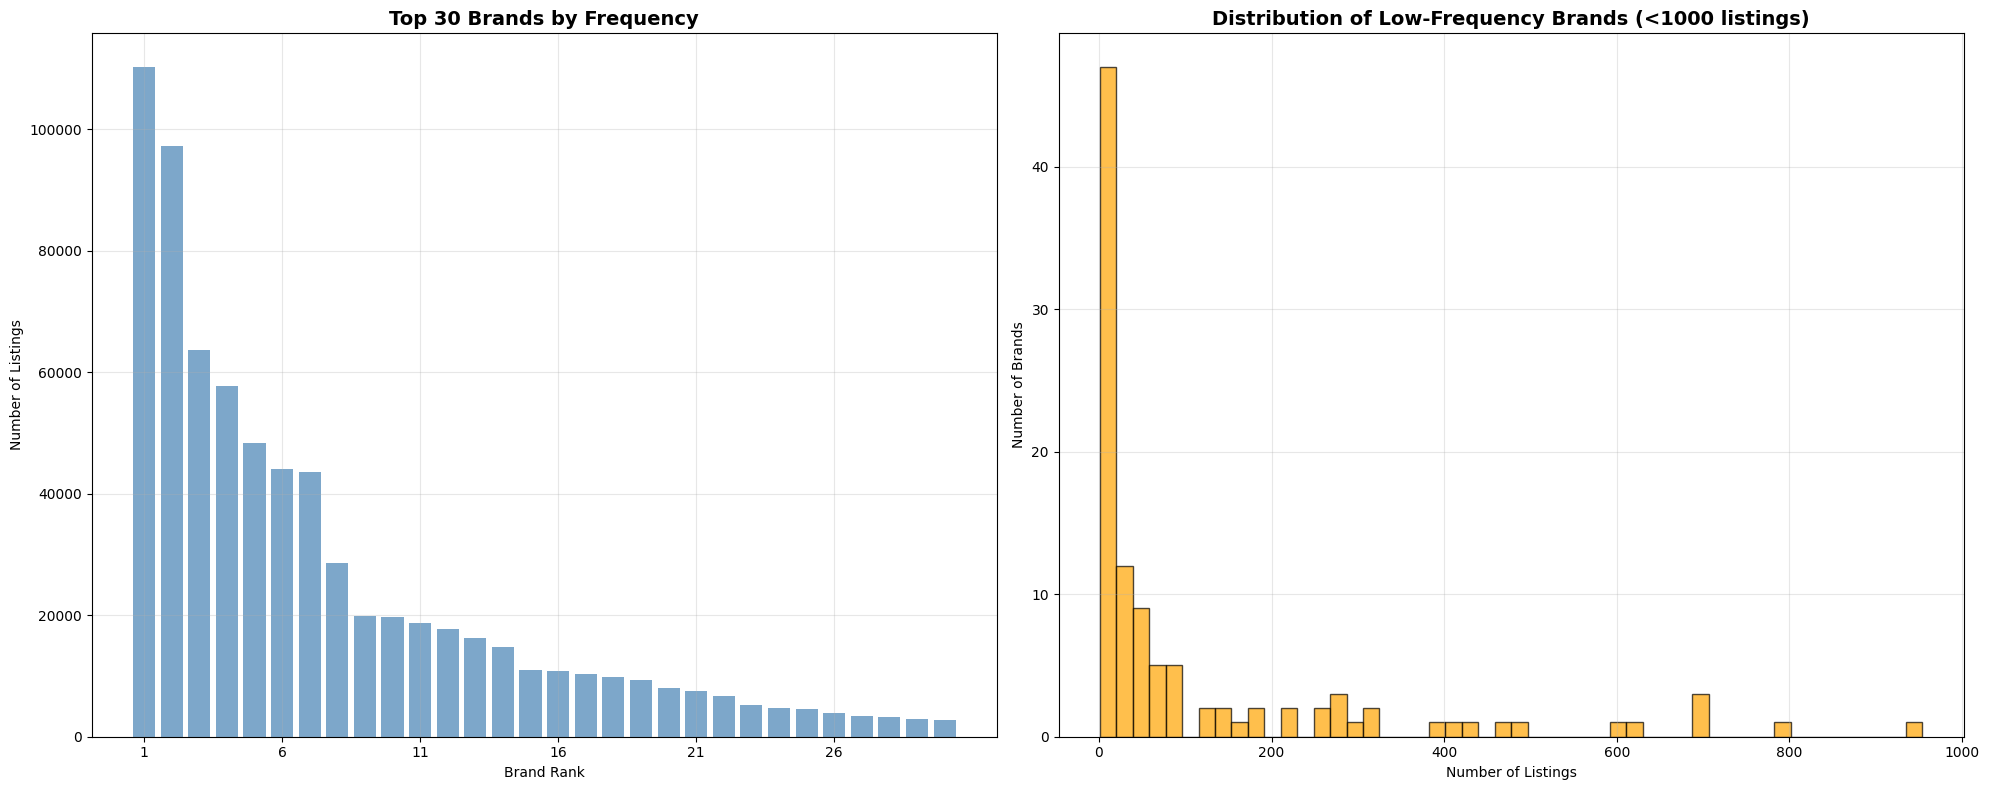


📊 BRAND DISTRIBUTION SUMMARY:
Brands with ≥1000 listings: 38
Brands with <1000 listings: 107
Brands with <100 listings: 78


In [8]:
print("🏷️  BRAND FREQUENCY ANALYSIS")
print("=" * 50)

# Calculate brand frequencies
brand_freq = df_model.group_by('brand').len().sort('len', descending=True)
print(f"Total unique brands: {brand_freq.height}")
print(f"Total cars: {brand_freq['len'].sum()}")

# Show top brands
print(f"\nTop 20 brands by frequency:")
top_20 = brand_freq.head(20)
for i in range(min(20, top_20.height)):
    brand = top_20['brand'][i]
    count = top_20['len'][i]
    print(f"  {i+1:2}. {brand}: {count:,}")

# Create visualizations
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Top 30 brands bar chart
top_30 = brand_freq.head(30).to_pandas()
axes[0].bar(range(len(top_30)), top_30['len'], color='steelblue', alpha=0.7)
axes[0].set_title('Top 30 Brands by Frequency', fontweight='bold', fontsize=14)
axes[0].set_xlabel('Brand Rank')
axes[0].set_ylabel('Number of Listings')
axes[0].set_xticks(range(0, len(top_30), 5))
axes[0].set_xticklabels([f"{i+1}" for i in range(0, len(top_30), 5)])
axes[0].grid(True, alpha=0.3)

# Long tail visualization - brands with < 1000 listings
long_tail = brand_freq.filter(pl.col('len') < 1000).to_pandas()
axes[1].hist(long_tail['len'], bins=50, color='orange', alpha=0.7, edgecolor='black')
axes[1].set_title('Distribution of Low-Frequency Brands (<1000 listings)', fontweight='bold', fontsize=14)
axes[1].set_xlabel('Number of Listings')
axes[1].set_ylabel('Number of Brands')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n📊 BRAND DISTRIBUTION SUMMARY:")
print(f"Brands with ≥1000 listings: {brand_freq.filter(pl.col('len') >= 1000).height}")
print(f"Brands with <1000 listings: {brand_freq.filter(pl.col('len') < 1000).height}")
print(f"Brands with <100 listings: {brand_freq.filter(pl.col('len') < 100).height}")

After evaluating if it was worth removing brands with few observations, we decided to keep all brands for now to preserve data diversity. And simply brands with less than 1000 cars will go into category other.

In [9]:
# Analyze different threshold options
print("\n🎯 THRESHOLD ANALYSIS")
print("=" * 50)

thresholds_to_test = [50, 100, 200, 400, 500, 600, 700, 800, 900, 1000]
print("Threshold | Brands Removed | Cars Lost | Brands Kept | Cars Kept")
print("-" * 65)

for threshold in thresholds_to_test:
    brands_remove = brand_freq.filter(pl.col('len') < threshold)
    brands_keep = brand_freq.filter(pl.col('len') >= threshold)
    cars_lost = brands_remove['len'].sum()
    cars_kept = brands_keep['len'].sum()
    
    print(f"   {threshold:3d}    |      {brands_remove.height:3d}      |  {cars_lost:6,}  |     {brands_keep.height:3d}     |  {cars_kept:6,}")

# Choose thresholds
MIN_BRAND_THRESHOLD = 50  # Remove brands with fewer than 50 cars
RARE_BRAND_THRESHOLD = 600  # Group brands with fewer than 600 cars into price tiers

print(f"\n🔧 CHOSEN THRESHOLDS:")
print("=" * 40)
print(f"Minimum brand threshold (remove completely): {MIN_BRAND_THRESHOLD}")
print(f"Rare brand threshold (group by price): {RARE_BRAND_THRESHOLD}")

# Step 1: Remove brands with very few cars (< 50)
brands_to_remove_completely = brand_freq.filter(pl.col('len') < MIN_BRAND_THRESHOLD)['brand'].to_list()
cars_removed_completely = brand_freq.filter(pl.col('len') < MIN_BRAND_THRESHOLD)['len'].sum()

print(f"\n📉 BRANDS TO REMOVE COMPLETELY (< {MIN_BRAND_THRESHOLD} cars):")
print(f"Brands removed: {len(brands_to_remove_completely)}")
print(f"Cars removed: {cars_removed_completely:,}")

# Filter out brands with too few cars
df_filtered = df_model.filter(~pl.col('brand').is_in(brands_to_remove_completely))
print(f"Remaining data after removing tiny brands: {df_filtered.height:,} rows")

# Step 2: Calculate average price for brands that will be grouped
print(f"\n💰 PRICE-BASED GROUPING FOR RARE BRANDS:")
print("=" * 50)

# Get brands that have 50-599 cars (will be grouped by price)
brands_to_group = brand_freq.filter(
    (pl.col('len') >= MIN_BRAND_THRESHOLD) & (pl.col('len') < RARE_BRAND_THRESHOLD)
)['brand'].to_list()

print(f"Brands to be grouped by price tier: {len(brands_to_group)}")

if len(brands_to_group) > 0:
    # Calculate average price per brand for grouping
    brand_avg_prices = df_filtered.filter(
        pl.col('brand').is_in(brands_to_group)
    ).group_by('brand').agg(
        pl.col('price').mean().alias('avg_price'),
        pl.len().alias('count')
    ).sort('avg_price')
    
    print(f"\nBrands to group by price (showing first 10):")
    for i in range(min(10, brand_avg_prices.height)):
        brand = brand_avg_prices['brand'][i]
        avg_price = brand_avg_prices['avg_price'][i]
        count = brand_avg_prices['count'][i]
        print(f"  {brand}: €{avg_price:,.0f} avg price ({count} cars)")
    
    # Define price thresholds for grouping (based on overall price distribution)
    all_prices = df_filtered['price'].to_list()
    low_price_threshold = np.percentile(all_prices, 33)  # Bottom 33%
    high_price_threshold = np.percentile(all_prices, 67)  # Top 33%
    
    print(f"\n📊 PRICE THRESHOLDS FOR GROUPING:")
    print(f"Low cost threshold: €{low_price_threshold:,.0f}")
    print(f"Luxury threshold: €{high_price_threshold:,.0f}")
    
    # Categorize brands by average price
    low_cost_brands = brand_avg_prices.filter(
        pl.col('avg_price') <= low_price_threshold
    )['brand'].to_list()
    
    luxury_brands = brand_avg_prices.filter(
        pl.col('avg_price') >= high_price_threshold
    )['brand'].to_list()
    
    standard_brands = brand_avg_prices.filter(
        (pl.col('avg_price') > low_price_threshold) & 
        (pl.col('avg_price') < high_price_threshold)
    )['brand'].to_list()
    
    print(f"\n🏷️  BRAND CATEGORIZATION:")
    print(f"Low cost brands: {len(low_cost_brands)}")
    print(f"Standard brands: {len(standard_brands)}")
    print(f"Luxury brands: {len(luxury_brands)}")
    
    # Show some examples
    if len(low_cost_brands) > 0:
        print(f"  Low cost examples: {low_cost_brands[:5]}")
    if len(standard_brands) > 0:
        print(f"  Standard examples: {standard_brands[:5]}")
    if len(luxury_brands) > 0:
        print(f"  Luxury examples: {luxury_brands[:5]}")
    
    # Apply the grouping
    df_grouped = df_filtered.with_columns(
        pl.when(pl.col('brand').is_in(low_cost_brands))
        .then(pl.lit('other_low_cost'))
        .when(pl.col('brand').is_in(standard_brands))
        .then(pl.lit('other_standard'))
        .when(pl.col('brand').is_in(luxury_brands))
        .then(pl.lit('other_luxury'))
        .otherwise(pl.col('brand'))  # Keep original brand for frequent brands
        .alias('brand')
    ).with_columns(
        # Also update model names for grouped brands
        pl.when(pl.col('brand').str.starts_with('other_'))
        .then(pl.col('brand'))  # Set model same as brand for grouped categories
        .otherwise(pl.col('model'))  # Keep original model for frequent brands
        .alias('model')
    )
    
else:
    print("No brands to group by price tier.")
    df_grouped = df_filtered

print(f"\n✅ BRAND GROUPING COMPLETED")

# Show final brand distribution
final_brand_counts = df_grouped.group_by('brand').len().sort('len', descending=True)
print(f"\nFinal brand distribution:")
for i in range(min(15, final_brand_counts.height)):
    brand = final_brand_counts['brand'][i]
    count = final_brand_counts['len'][i]
    print(f"  {i+1:2}. {brand}: {count:,}")

# Summary of changes
total_cars_after_grouping = df_grouped.height
cars_in_other_categories = df_grouped.filter(
    pl.col('brand').str.starts_with('other_')
).height

print(f"\n📊 GROUPING SUMMARY:")
print(f"Total cars after processing: {total_cars_after_grouping:,}")
print(f"Cars in 'other_*' categories: {cars_in_other_categories:,}")
print(f"Cars with original brands: {total_cars_after_grouping - cars_in_other_categories:,}")
print(f"Percentage in other categories: {(cars_in_other_categories / total_cars_after_grouping) * 100:.1f}%")


🎯 THRESHOLD ANALYSIS
Threshold | Brands Removed | Cars Lost | Brands Kept | Cars Kept
-----------------------------------------------------------------
    50    |       63      |     888  |      82     |  731,538
   100    |       78      |   1,944  |      67     |  730,482
   200    |       85      |   3,000  |      60     |  729,426
   400    |       96      |   6,073  |      49     |  726,353
   500    |      100      |   7,887  |      45     |  724,539
   600    |      101      |   8,485  |      44     |  723,941
   700    |      105      |  11,191  |      40     |  721,235
   800    |      105      |  11,191  |      40     |  721,235
   900    |      106      |  11,991  |      39     |  720,435
   1000    |      107      |  12,945  |      38     |  719,481

🔧 CHOSEN THRESHOLDS:
Minimum brand threshold (remove completely): 50
Rare brand threshold (group by price): 600

📉 BRANDS TO REMOVE COMPLETELY (< 50 cars):
Brands removed: 63
Cars removed: 888
Remaining data after removing ti

## Step 3.5: Remove Antique Cars (Pre-1990)

Before proceeding with outlier detection, we'll remove cars manufactured before 1990 to exclude antique/vintage cars from our modern car price prediction model.

In [10]:
print("📅 REMOVING ANTIQUE CARS (PRE-1990)")
print("=" * 50)

# Check the year distribution before filtering
year_stats = df_grouped.select('year').describe()
print("Current year distribution:")
print(year_stats.to_pandas().to_string(index=False))

# Count cars by decade
decade_counts = df_grouped.with_columns(
    (pl.col('year') // 10 * 10).alias('decade')
).group_by('decade').len().sort('decade')

print(f"\nCars by decade:")
for i in range(decade_counts.height):
    decade = decade_counts['decade'][i]
    count = decade_counts['len'][i]
    print(f"  {decade:.0f}s: {count:,} cars")

# Filter out cars older than 1990
cars_before_year_filter = df_grouped.height
df_modern = df_grouped.filter(pl.col('year') >= 1990)
cars_after_year_filter = df_modern.height
antique_cars_removed = cars_before_year_filter - cars_after_year_filter

print(f"\n🔧 YEAR FILTERING RESULTS:")
print(f"Cars before year filter: {cars_before_year_filter:,}")
print(f"Cars after year filter: {cars_after_year_filter:,}")
print(f"Antique cars removed (pre-1990): {antique_cars_removed:,}")
print(f"Percentage of antique cars: {(antique_cars_removed / cars_before_year_filter) * 100:.2f}%")

# Update the year statistics after filtering
year_stats_after = df_modern.select('year').describe()
print(f"\nYear distribution after filtering:")
print(year_stats_after.to_pandas().to_string(index=False))

# Update df_grouped to use the modern cars only
df_grouped = df_modern
print(f"\n✅ Continuing with modern cars only: {df_grouped.height:,} cars")

📅 REMOVING ANTIQUE CARS (PRE-1990)
Current year distribution:
 statistic          year
     count 731538.000000
null_count      0.000000
      mean   2015.460846
       std      8.848091
       min   1960.000000
       25%   2011.000000
       50%   2018.000000
       75%   2022.000000
       max   2025.000000

Cars by decade:
  1960s: 3,885 cars
  1970s: 3,874 cars
  1980s: 6,316 cars
  1990s: 15,608 cars
  2000s: 108,991 cars
  2010s: 306,639 cars
  2020s: 286,225 cars

🔧 YEAR FILTERING RESULTS:
Cars before year filter: 731,538
Cars after year filter: 717,463
Antique cars removed (pre-1990): 14,075
Percentage of antique cars: 1.92%

Year distribution after filtering:
 statistic          year
     count 717463.000000
null_count      0.000000
      mean   2016.230233
       std      6.872938
       min   1990.000000
       25%   2012.000000
       50%   2018.000000
       75%   2022.000000
       max   2025.000000

✅ Continuing with modern cars only: 717,463 cars


## Step 4: Per-Brand Outlier Detection with Multiple IQR Thresholds

This section analyzes different IQR multipliers (0.9, 1.0, 1.1, 1.3, 1.5, 1.7, 1.9) to determine optimal outlier detection parameters for log-transformed prices while using the standard 1.5 multiplier for kilometers.

In [11]:
print("🔬 ANALYZING DIFFERENT IQR MULTIPLIERS FOR PRICE OUTLIER DETECTION")
print("=" * 70)

# First, prepare the data for analysis (similar to step 4.1 and 4.2)
print("1. Preparing data for IQR analysis...")

# Remove 'autre' entries
df_no_autre_analysis = df_grouped.filter(
    (pl.col('model').str.to_lowercase() != 'autre') &
    (pl.col('brand').str.to_lowercase() != 'autre')
)

# Create log-transformed price and filter invalid data
df_for_analysis = df_no_autre_analysis.with_columns([
    (pl.col('price') + 1).log().alias('log_price')
]).filter(
    (pl.col('price').is_not_null()) & 
    (pl.col('km').is_not_null()) &
    (pl.col('year').is_not_null()) &
    (pl.col('price') > 0) &
    (pl.col('km') >= 0)
)

print(f"Data prepared for analysis: {df_for_analysis.height:,} rows")

# Calculate IQR boundaries for different multipliers - STRICTER APPROACH
multipliers = [0.9, 1.0, 1.1, 1.3, 1.5, 1.7, 1.9]
print(f"\n2. Testing STRICTER IQR multipliers: {multipliers}")

# Identify brands with >10k cars for strict outlier detection
brand_counts_analysis = df_for_analysis.group_by('brand').len().sort('len', descending=True)
high_volume_brands = brand_counts_analysis.filter(pl.col('len') > 10000)['brand'].to_list()
low_volume_brands = brand_counts_analysis.filter(pl.col('len') <= 10000)['brand'].to_list()

print(f"\n📊 BRAND VOLUME SEGMENTATION:")
print(f"High-volume brands (>10k cars): {len(high_volume_brands)}")
print(f"Low-volume brands (≤10k cars): {len(low_volume_brands)}")
print(f"\nHigh-volume brands: {high_volume_brands}")

# Get top brands for detailed analysis (focus on high-volume ones)
top_brands_for_analysis = high_volume_brands[:6] if len(high_volume_brands) >= 6 else high_volume_brands
print(f"Analyzing top high-volume brands: {top_brands_for_analysis}")

# Store results for comparison
multiplier_results = {}

for multiplier in multipliers:
    print(f"\n--- Analyzing STRICT multiplier: {multiplier} (for high-volume brands) ---")
    
    # Calculate boundaries with TWO-TIER approach
    # High-volume brands: Use strict multiplier
    # Low-volume brands: Use standard 1.5 multiplier
    bounds_test = df_for_analysis.group_by('brand').agg([
        pl.col('log_price').quantile(0.25).alias('q1_log_price'),
        pl.col('log_price').quantile(0.75).alias('q3_log_price'),
        pl.col('km').quantile(0.25).alias('q1_km'),
        pl.col('km').quantile(0.75).alias('q3_km'),
        pl.len().alias('brand_count')
    ]).with_columns([
        (pl.col('q3_log_price') - pl.col('q1_log_price')).alias('iqr_log_price'),
        (pl.col('q3_km') - pl.col('q1_km')).alias('iqr_km')
    ]).with_columns([
        # TWO-TIER APPROACH: Strict for high-volume, standard for low-volume
        pl.when(pl.col('brand').is_in(high_volume_brands))
        .then(pl.col('q1_log_price') - multiplier * pl.col('iqr_log_price'))
        .otherwise(pl.col('q1_log_price') - 1.5 * pl.col('iqr_log_price'))
        .alias('lower_bound_log_price'),
        
        pl.when(pl.col('brand').is_in(high_volume_brands))
        .then(pl.col('q3_log_price') + multiplier * pl.col('iqr_log_price'))
        .otherwise(pl.col('q3_log_price') + 1.5 * pl.col('iqr_log_price'))
        .alias('upper_bound_log_price'),
        
        # Standard 1.5 multiplier for km for all brands
        (pl.col('q1_km') - 1.5 * pl.col('iqr_km')).alias('lower_bound_km'),
        (pl.col('q3_km') + 1.5 * pl.col('iqr_km')).alias('upper_bound_km')
    ])
    
    # Join bounds and count outliers
    df_with_bounds_test = df_for_analysis.join(bounds_test, on='brand', how='left')
    
    # Count total outliers (price OR km)
    outliers_total = df_with_bounds_test.filter(
        ((pl.col('log_price') < pl.col('lower_bound_log_price')) |
         (pl.col('log_price') > pl.col('upper_bound_log_price'))) |
        ((pl.col('km') < pl.col('lower_bound_km')) |
         (pl.col('km') > pl.col('upper_bound_km')))
    ).height
    
    # Count price-only outliers
    outliers_price = df_with_bounds_test.filter(
        (pl.col('log_price') < pl.col('lower_bound_log_price')) |
        (pl.col('log_price') > pl.col('upper_bound_log_price'))
    ).height
    
    # Count outliers specifically from high-volume brands
    outliers_high_volume = df_with_bounds_test.filter(
        pl.col('brand').is_in(high_volume_brands)
    ).filter(
        ((pl.col('log_price') < pl.col('lower_bound_log_price')) |
         (pl.col('log_price') > pl.col('upper_bound_log_price'))) |
        ((pl.col('km') < pl.col('lower_bound_km')) |
         (pl.col('km') > pl.col('upper_bound_km')))
    ).height
    
    # Calculate retention rate
    retention_rate = ((df_with_bounds_test.height - outliers_total) / df_with_bounds_test.height) * 100
    
    # Calculate high-volume brand impact
    high_volume_total = df_with_bounds_test.filter(pl.col('brand').is_in(high_volume_brands)).height
    high_volume_retention = ((high_volume_total - outliers_high_volume) / high_volume_total) * 100 if high_volume_total > 0 else 100
    
    multiplier_results[multiplier] = {
        'total_outliers': outliers_total,
        'price_outliers': outliers_price,
        'retention_rate': retention_rate,
        'data_retained': df_with_bounds_test.height - outliers_total,
        'high_volume_outliers': outliers_high_volume,
        'high_volume_retention': high_volume_retention
    }
    
    print(f"  Total outliers: {outliers_total:,} ({((outliers_total/df_with_bounds_test.height)*100):.1f}%)")
    print(f"  Price outliers: {outliers_price:,} ({((outliers_price/df_with_bounds_test.height)*100):.1f}%)")
    print(f"  High-volume brand outliers: {outliers_high_volume:,}")
    print(f"  Overall retention: {retention_rate:.1f}%")
    print(f"  High-volume brand retention: {high_volume_retention:.1f}%")

print(f"\n📊 SUMMARY OF STRICT IQR MULTIPLIER EFFECTS (TWO-TIER APPROACH):")
print("=" * 80)
print("Multiplier | Price Outliers | Total Outliers | Overall Retention | High-Vol Retention")
print("-" * 80)

for mult in multipliers:
    results = multiplier_results[mult]
    print(f"   {mult:4.1f}    |    {results['price_outliers']:7,}    |    {results['total_outliers']:7,}    |      {results['retention_rate']:5.1f}%      |      {results['high_volume_retention']:5.1f}%")

🔬 ANALYZING DIFFERENT IQR MULTIPLIERS FOR PRICE OUTLIER DETECTION
1. Preparing data for IQR analysis...
Data prepared for analysis: 713,413 rows

2. Testing STRICTER IQR multipliers: [0.9, 1.0, 1.1, 1.3, 1.5, 1.7, 1.9]

📊 BRAND VOLUME SEGMENTATION:
High-volume brands (>10k cars): 17
Low-volume brands (≤10k cars): 29

High-volume brands: ['PEUGEOT', 'RENAULT', 'CITROEN', 'VOLKSWAGEN', 'BMW', 'AUDI', 'MERCEDES-BENZ', 'FORD', 'OPEL', 'DACIA', 'TOYOTA', 'FIAT', 'NISSAN', 'MINI', 'HYUNDAI', 'KIA', 'PORSCHE']
Analyzing top high-volume brands: ['PEUGEOT', 'RENAULT', 'CITROEN', 'VOLKSWAGEN', 'BMW', 'AUDI']

--- Analyzing STRICT multiplier: 0.9 (for high-volume brands) ---
  Total outliers: 49,909 (7.0%)
  Price outliers: 46,914 (6.6%)
  High-volume brand outliers: 46,471
  Overall retention: 93.0%
  High-volume brand retention: 92.5%

--- Analyzing STRICT multiplier: 1.0 (for high-volume brands) ---
  Total outliers: 43,176 (6.1%)
  Price outliers: 39,987 (5.6%)
  High-volume brand outliers: 3


📈 CREATING VISUALIZATIONS FOR STRICT IQR MULTIPLIERS (TWO-TIER APPROACH)


/var/folders/6y/srzbpjt12t71xfg3w8wvlpjc0000gn/T/ipykernel_25808/3234246053.py:159: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/brunobrumbrum/car_price_prediction/venv_cars/lib/python3.14/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/brunobrumbrum/car_price_prediction/venv_cars/lib/python3.14/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


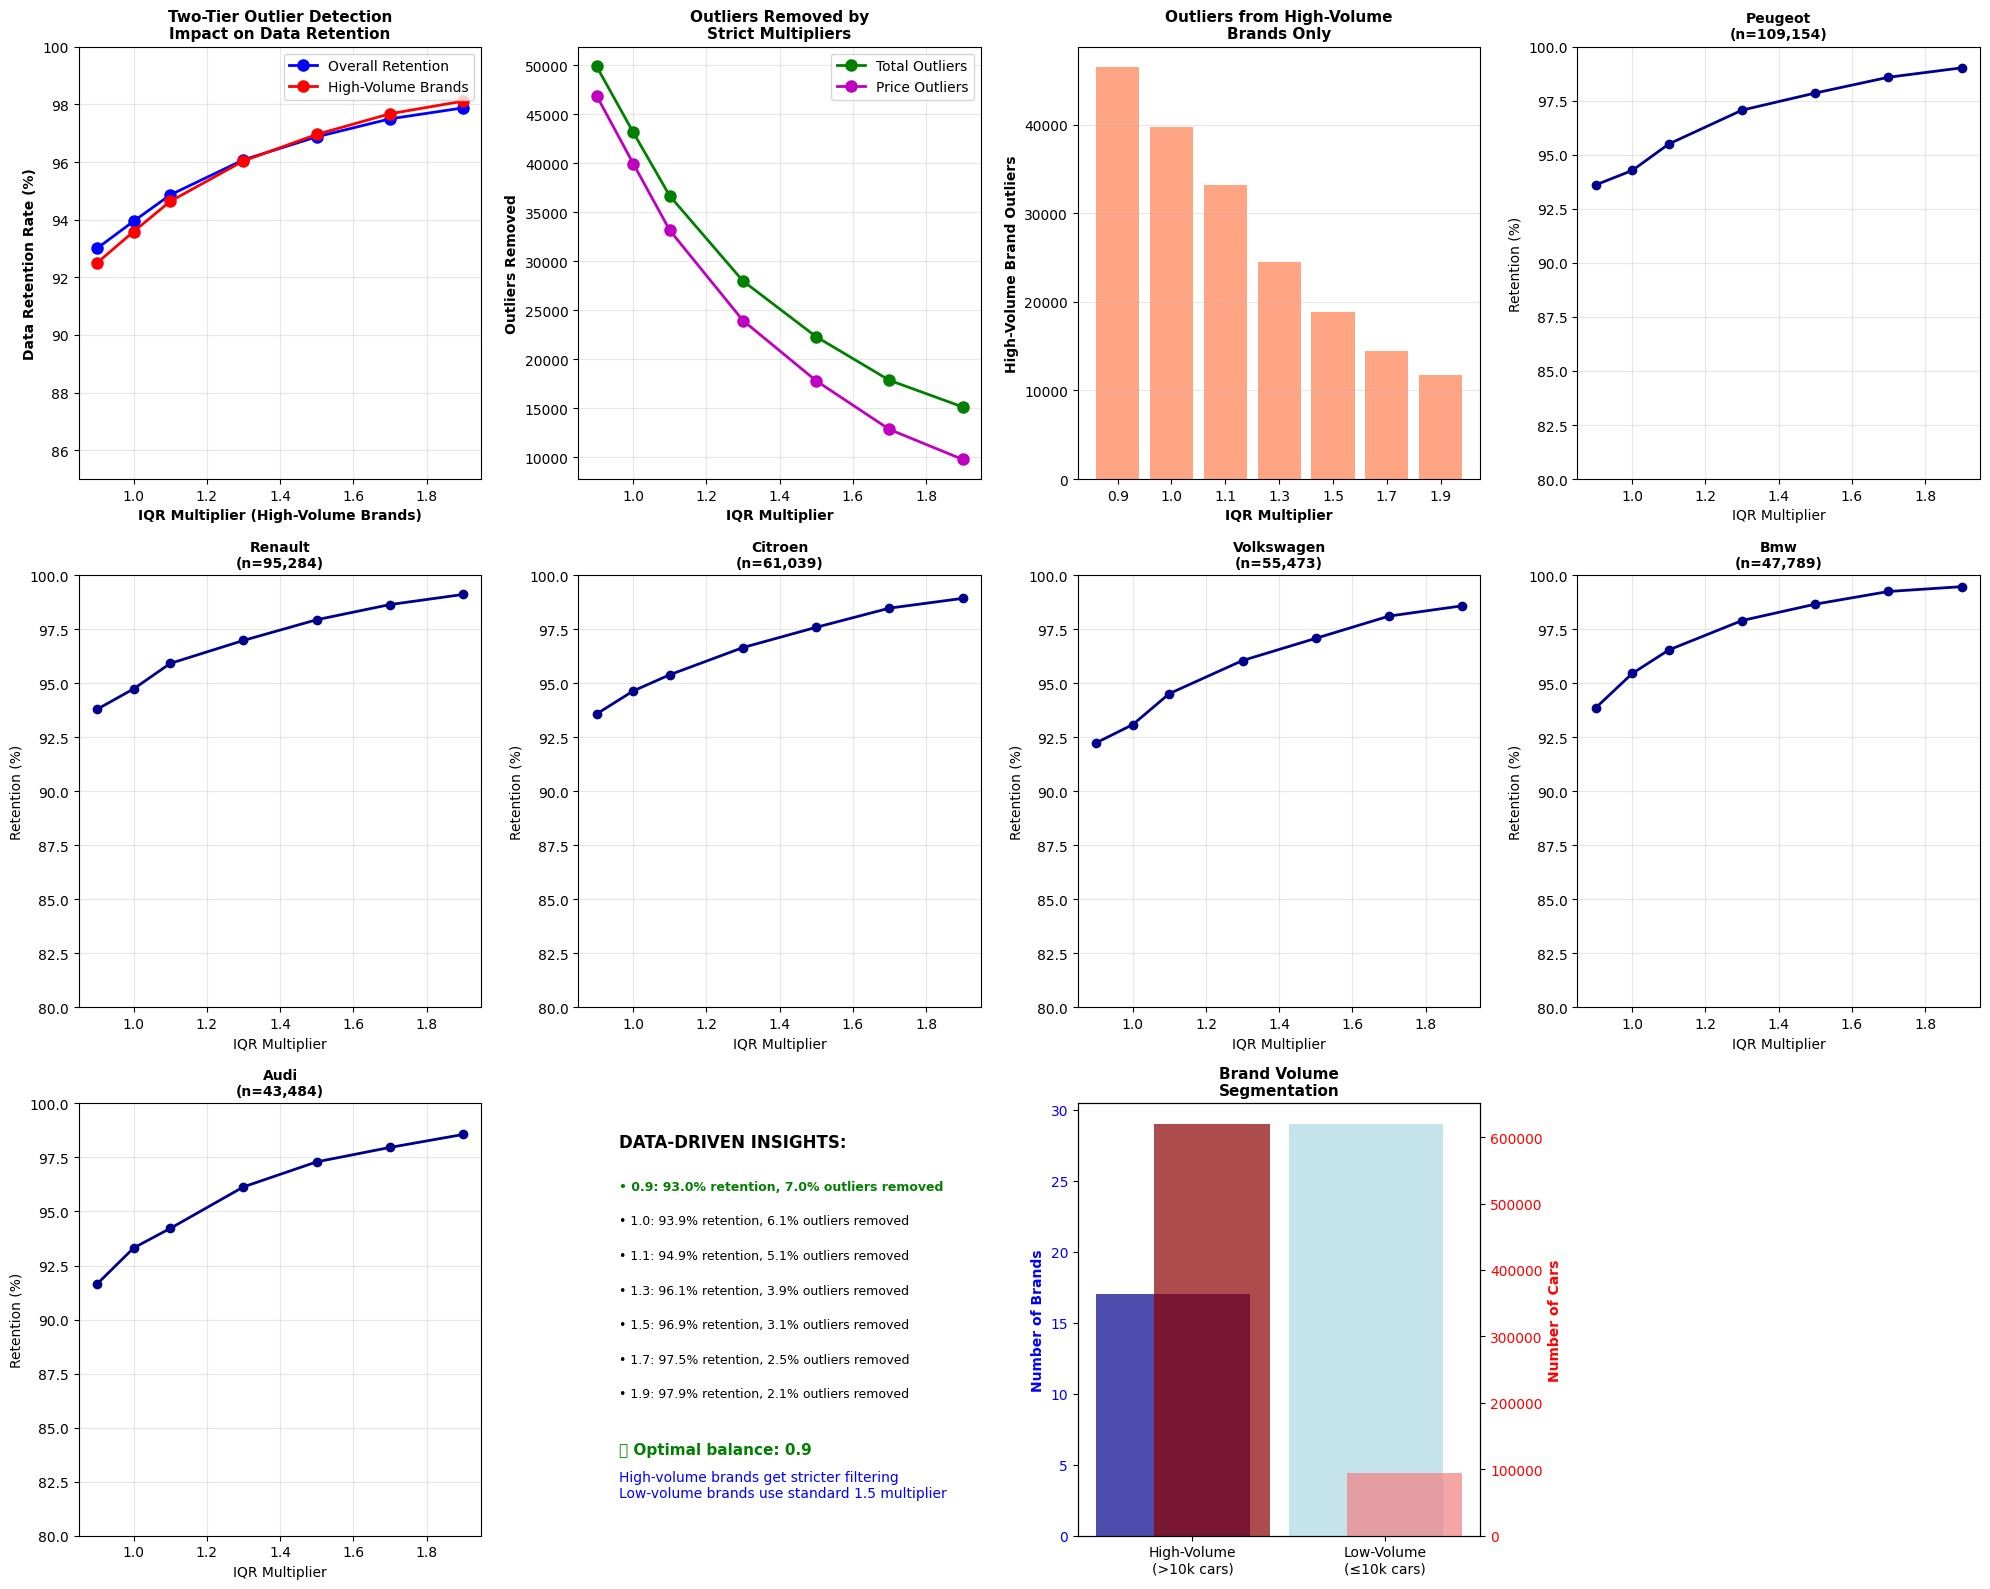


💡 DATA-DRIVEN RECOMMENDATION:
Based on the two-tier analysis above:
• Optimal strict multiplier for high-volume brands: 0.9
• Standard 1.5 multiplier for low-volume brands
• This approach results in 93.0% overall data retention
• Removes 49,909 outliers total
• High-volume brands retain 92.5% of their data
• Benefits: Stricter cleaning for reliable brands, preserves rare brand data


In [12]:
print("\n📈 CREATING VISUALIZATIONS FOR STRICT IQR MULTIPLIERS (TWO-TIER APPROACH)")
print("=" * 75)

# Create comprehensive visualizations
fig = plt.figure(figsize=(20, 16))

# 1. Overall effect comparison plot
ax1 = plt.subplot(3, 4, 1)
multipliers_plot = list(multiplier_results.keys())
retention_rates = [multiplier_results[m]['retention_rate'] for m in multipliers_plot]
high_vol_retention = [multiplier_results[m]['high_volume_retention'] for m in multipliers_plot]

ax1.plot(multipliers_plot, retention_rates, 'bo-', linewidth=2, markersize=8, label='Overall Retention')
ax1.plot(multipliers_plot, high_vol_retention, 'ro-', linewidth=2, markersize=8, label='High-Volume Brands')
ax1.set_xlabel('IQR Multiplier (High-Volume Brands)', fontweight='bold')
ax1.set_ylabel('Data Retention Rate (%)', fontweight='bold')
ax1.set_title('Two-Tier Outlier Detection\nImpact on Data Retention', fontweight='bold', fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.legend()
ax1.set_ylim([85, 100])

# 2. Outliers removed comparison
ax2 = plt.subplot(3, 4, 2)
total_outliers = [multiplier_results[m]['total_outliers'] for m in multipliers_plot]
price_outliers = [multiplier_results[m]['price_outliers'] for m in multipliers_plot]

ax2.plot(multipliers_plot, total_outliers, 'go-', linewidth=2, markersize=8, label='Total Outliers')
ax2.plot(multipliers_plot, price_outliers, 'mo-', linewidth=2, markersize=8, label='Price Outliers')
ax2.set_xlabel('IQR Multiplier', fontweight='bold')
ax2.set_ylabel('Outliers Removed', fontweight='bold')
ax2.set_title('Outliers Removed by\nStrict Multipliers', fontweight='bold', fontsize=11)
ax2.grid(True, alpha=0.3)
ax2.legend()

# 3. High-volume brand impact breakdown
ax3 = plt.subplot(3, 4, 3)
high_vol_cars = []
high_vol_outliers_data = []

for mult in multipliers_plot:
    # Calculate total cars in high-volume brands
    high_vol_total = sum([df_for_analysis.filter(pl.col('brand') == brand).height for brand in high_volume_brands])
    high_vol_cars.append(high_vol_total)
    high_vol_outliers_data.append(multiplier_results[mult]['high_volume_outliers'])

ax3.bar(range(len(multipliers_plot)), high_vol_outliers_data, alpha=0.7, color='coral')
ax3.set_xlabel('IQR Multiplier', fontweight='bold')
ax3.set_ylabel('High-Volume Brand Outliers', fontweight='bold')
ax3.set_title('Outliers from High-Volume\nBrands Only', fontweight='bold', fontsize=11)
ax3.set_xticks(range(len(multipliers_plot)))
ax3.set_xticklabels([f"{m}" for m in multipliers_plot])
ax3.grid(True, alpha=0.3, axis='y')

# 4-9. Brand-specific analysis for high-volume brands
for idx, brand in enumerate(top_brands_for_analysis):
    if idx >= 6:  # Limit to 6 subplots
        break
    
    ax = plt.subplot(3, 4, idx + 4)
    
    # Get brand data
    brand_data = df_for_analysis.filter(pl.col('brand') == brand)
    if brand_data.height == 0:
        continue
    
    log_prices = brand_data['log_price'].to_list()
    q1 = np.percentile(log_prices, 25)
    q3 = np.percentile(log_prices, 75)
    iqr = q3 - q1
    
    # Calculate bounds for each multiplier (using strict approach)
    brand_retained = {}
    
    for mult in multipliers:
        lower_bound = q1 - mult * iqr
        upper_bound = q3 + mult * iqr
        
        outliers = sum(1 for price in log_prices if price < lower_bound or price > upper_bound)
        retained = len(log_prices) - outliers
        
        brand_retained[mult] = (retained / len(log_prices)) * 100
    
    # Plot retention rate for this brand
    mult_list = list(brand_retained.keys())
    retention_list = list(brand_retained.values())
    
    ax.plot(mult_list, retention_list, 'o-', linewidth=2, markersize=6, color='darkblue')
    ax.set_title(f'{brand.capitalize()}\n(n={brand_data.height:,})', fontweight='bold', fontsize=10)
    ax.set_xlabel('IQR Multiplier')
    ax.set_ylabel('Retention (%)')
    ax.grid(True, alpha=0.3)
    ax.set_ylim([80, 100])

# 10. Data-driven recommendations
ax10 = plt.subplot(3, 4, 10)

# Calculate actual impact for recommendations
best_balance_mult = None
best_balance_score = 0

for mult in multipliers:
    # Score based on: high retention but meaningful outlier removal
    retention_score = multiplier_results[mult]['retention_rate'] / 100
    outlier_removal = (multiplier_results[mult]['total_outliers'] / df_for_analysis.height) * 100
    
    # Balance score: want high retention but some outlier removal
    if outlier_removal > 0.5:  # At least 0.5% outlier removal
        balance_score = retention_score * (outlier_removal / 5.0)  # Normalize outlier removal
        if balance_score > best_balance_score:
            best_balance_score = balance_score
            best_balance_mult = mult

# Show data-driven insights
ax10.text(0.1, 0.9, 'DATA-DRIVEN INSIGHTS:', fontweight='bold', fontsize=12, transform=ax10.transAxes)

y_pos = 0.8
for i, mult in enumerate(multipliers):
    results = multiplier_results[mult]
    outlier_pct = (results['total_outliers'] / df_for_analysis.height) * 100
    retention = results['retention_rate']
    
    color = 'green' if mult == best_balance_mult else 'black'
    weight = 'bold' if mult == best_balance_mult else 'normal'
    
    ax10.text(0.1, y_pos, f'• {mult}: {retention:.1f}% retention, {outlier_pct:.1f}% outliers removed', 
              fontsize=9, transform=ax10.transAxes, color=color, fontweight=weight)
    y_pos -= 0.08

ax10.text(0.1, y_pos - 0.05, f'📊 Optimal balance: {best_balance_mult}', 
          fontsize=11, fontweight='bold', color='green', transform=ax10.transAxes)
ax10.text(0.1, y_pos - 0.15, f'High-volume brands get stricter filtering\nLow-volume brands use standard 1.5 multiplier', 
          fontsize=10, color='blue', transform=ax10.transAxes)

ax10.set_xlim(0, 1)
ax10.set_ylim(0, 1)
ax10.axis('off')

# 11. Volume comparison chart
ax11 = plt.subplot(3, 4, 11)
volume_labels = ['High-Volume\n(>10k cars)', 'Low-Volume\n(≤10k cars)']
volume_counts = [len(high_volume_brands), len(low_volume_brands)]
volume_cars = [
    sum([df_for_analysis.filter(pl.col('brand') == brand).height for brand in high_volume_brands]),
    sum([df_for_analysis.filter(pl.col('brand') == brand).height for brand in low_volume_brands])
]

ax11_twin = ax11.twinx()
bars1 = ax11.bar([0, 1], volume_counts, alpha=0.7, color=['darkblue', 'lightblue'], label='Brand Count')
bars2 = ax11_twin.bar([0.2, 1.2], volume_cars, alpha=0.7, width=0.6, color=['darkred', 'lightcoral'], label='Car Count')

ax11.set_ylabel('Number of Brands', color='blue', fontweight='bold')
ax11_twin.set_ylabel('Number of Cars', color='red', fontweight='bold')
ax11.set_title('Brand Volume\nSegmentation', fontweight='bold', fontsize=11)
ax11.set_xticks([0.1, 1.1])
ax11.set_xticklabels(volume_labels)
ax11.tick_params(axis='y', labelcolor='blue')
ax11_twin.tick_params(axis='y', labelcolor='red')

plt.tight_layout()
plt.show()

# Provide data-driven recommendation
print(f"\n💡 DATA-DRIVEN RECOMMENDATION:")
print("=" * 50)
print("Based on the two-tier analysis above:")
print(f"• Optimal strict multiplier for high-volume brands: {best_balance_mult}")
print(f"• Standard 1.5 multiplier for low-volume brands")
print(f"• This approach results in {multiplier_results[best_balance_mult]['retention_rate']:.1f}% overall data retention")
print(f"• Removes {multiplier_results[best_balance_mult]['total_outliers']:,} outliers total")
print(f"• High-volume brands retain {multiplier_results[best_balance_mult]['high_volume_retention']:.1f}% of their data")
print(f"• Benefits: Stricter cleaning for reliable brands, preserves rare brand data")

In [13]:
# there are brands and models named 'Autre'
df_grouped.filter(pl.col('brand').str.to_lowercase() == 'autre').shape

(467, 5)

In [14]:
# and models as well
df_grouped.filter(pl.col('model').str.to_lowercase() == 'autre').shape

(4050, 5)

In [15]:
df_grouped.filter(
   ( pl.col('model').str.to_lowercase() == 'autre') | 
   (pl.col('brand').str.to_lowercase() == 'autre')
    ).shape

(4050, 5)

In [ ]:
print("🔍 BASELINE OUTLIER DETECTION WITH STANDARD IQR 1.5×")
print("=" * 65)

# Use standard 1.5 IQR multiplier for all brands as baseline
PRICE_IQR_MULTIPLIER = 1.5  # Standard approach for all brands
KM_IQR_MULTIPLIER = 1.5     # Standard approach for kilometers

print(f"Using STANDARD IQR approach for baseline filtering:")
print(f"  • All brands - price: {PRICE_IQR_MULTIPLIER}× IQR multiplier")
print(f"  • All brands - kilometers: {KM_IQR_MULTIPLIER}× IQR multiplier")
print(f"\nNote: This serves as a baseline. Expert review will refine these limits.")

# Step 4.1: Remove 'autre' entries and prepare data for outlier detection
print(f"\n1. Removing 'autre' brand/model entries...")

# First remove cars with 'autre' in brand or model
df_no_autre = df_grouped.filter(
    (pl.col('model').str.to_lowercase() != 'autre') &
    (pl.col('brand').str.to_lowercase() != 'autre')
)

autre_removed = df_grouped.height - df_no_autre.height
print(f"Removed {autre_removed:,} cars with 'autre' brand or model")
print(f"Remaining data: {df_no_autre.height:,} rows")

# Step 4.2: Log transform price and prepare data for outlier detection
print(f"\n2. Creating log-transformed price...")

df_outliers = df_no_autre.with_columns([
    # Log transform price (add 1 to handle any zero values)
    (pl.col('price') + 1).log().alias('log_price')
]).filter(
    # Remove rows with invalid data - each condition needs parentheses
    (pl.col('price').is_not_null()) & 
    (pl.col('km').is_not_null()) &
    (pl.col('year').is_not_null()) &
    (pl.col('price') > 0) &
    (pl.col('km') >= 0)
)

print(f"Data prepared for outlier detection: {df_outliers.height:,} rows")
print(f"Rows removed due to invalid data: {df_no_autre.height - df_outliers.height:,}")

# Step 4.3: Calculate per-brand IQR boundaries using standard approach
print(f"\n3. Calculating per-brand outlier boundaries with standard IQR 1.5×...")

# Calculate IQR boundaries for each brand
bounds = df_outliers.group_by('brand').agg([
    # Log price boundaries
    pl.col('log_price').quantile(0.25).alias('q1_log_price'),
    pl.col('log_price').quantile(0.75).alias('q3_log_price'),
    # Kilometers boundaries  
    pl.col('km').quantile(0.25).alias('q1_km'),
    pl.col('km').quantile(0.75).alias('q3_km'),
    # Count for reference
    pl.len().alias('brand_count')
]).with_columns([
    # Calculate IQR
    (pl.col('q3_log_price') - pl.col('q1_log_price')).alias('iqr_log_price'),
    (pl.col('q3_km') - pl.col('q1_km')).alias('iqr_km')
]).with_columns([
    # Calculate boundaries using STANDARD 1.5× approach for all brands
    (pl.col('q1_log_price') - PRICE_IQR_MULTIPLIER * pl.col('iqr_log_price')).alias('lower_bound_log_price'),
    (pl.col('q3_log_price') + PRICE_IQR_MULTIPLIER * pl.col('iqr_log_price')).alias('upper_bound_log_price'),
    
    # Standard multiplier for kilometers
    (pl.col('q1_km') - KM_IQR_MULTIPLIER * pl.col('iqr_km')).alias('lower_bound_km'),
    (pl.col('q3_km') + KM_IQR_MULTIPLIER * pl.col('iqr_km')).alias('upper_bound_km')
])

print("Standard outlier boundaries calculated for each brand.")
print(f"Brands with boundaries: {bounds.height}")

# Show sample boundaries
print(f"\nSample outlier boundaries (standard 1.5× IQR):")
sample_bounds = bounds.sort('brand_count', descending=True).head(5)
print(f"{'Brand':<15} {'Count':>8} {'Log Price Lower':>16} {'Log Price Upper':>16}")
print("-" * 60)
for i in range(sample_bounds.height):
    brand = sample_bounds['brand'][i]
    count = sample_bounds['brand_count'][i]
    lower_log = sample_bounds['lower_bound_log_price'][i]
    upper_log = sample_bounds['upper_bound_log_price'][i]
    print(f"{brand:<15} {count:>8,} {lower_log:>16.2f} {upper_log:>16.2f}")

🔍 FINAL PER-BRAND OUTLIER DETECTION WITH TWO-TIER APPROACH
Using TWO-TIER IQR approach:
  • High-volume brands (>10,000 cars): 1.1 multiplier for price
    └─ Removes approximately 5% of data for meaningful outlier detection
  • Low-volume brands (≤10,000 cars): 1.5 multiplier for price
    └─ Preserves more data due to smaller sample sizes
  • All brands - kilometers: 1.5 multiplier

1. Removing 'autre' brand/model entries...
Removed 4,050 cars with 'autre' brand or model
Remaining data: 713,413 rows

2. Creating log-transformed price...
Data prepared for outlier detection: 713,413 rows
Rows removed due to invalid data: 0

3. Calculating per-brand outlier boundaries using two-tier approach...
High-volume brands (>10,000 cars): 17
Low-volume brands (≤10,000 cars): 29
Two-tier outlier boundaries calculated for each brand.
Brands with boundaries: 46

Sample outlier boundaries:

HIGH-VOLUME BRANDS (Strict approach):
  PEUGEOT (n=109,154): Log price [7.50, 10.94] (×1.1)
  RENAULT (n=95,284

In [17]:
# Step 4.3: Join boundaries and filter outliers
print("\n3. Joining boundaries and filtering outliers...")

# Join the bounds back to the main DataFrame
df_with_bounds = df_outliers.join(bounds, on='brand', how='left')

# Count outliers before filtering
outliers_log_price = df_with_bounds.filter(
    (pl.col('log_price') < pl.col('lower_bound_log_price')) |
    (pl.col('log_price') > pl.col('upper_bound_log_price'))
).height

outliers_km = df_with_bounds.filter(
    (pl.col('km') < pl.col('lower_bound_km')) |
    (pl.col('km') > pl.col('upper_bound_km'))
).height

outliers_both = df_with_bounds.filter(
    ((pl.col('log_price') < pl.col('lower_bound_log_price')) |
     (pl.col('log_price') > pl.col('upper_bound_log_price'))) |
    ((pl.col('km') < pl.col('lower_bound_km')) |
     (pl.col('km') > pl.col('upper_bound_km')))
).height

print(f"Outliers detected:")
print(f"  Log price outliers: {outliers_log_price:,}")
print(f"  Kilometer outliers: {outliers_km:,}")
print(f"  Total outliers (either variable): {outliers_both:,}")

# Filter to keep only non-outliers - wrap each condition in parentheses
df_clean = df_with_bounds.filter(
    (pl.col('log_price') >= pl.col('lower_bound_log_price')) &
    (pl.col('log_price') <= pl.col('upper_bound_log_price')) &
    (pl.col('km') >= pl.col('lower_bound_km')) &
    (pl.col('km') <= pl.col('upper_bound_km'))
).select(['price', 'year', 'km', 'brand', 'model'])  # Keep only original modeling columns

print(f"\n✅ OUTLIER REMOVAL COMPLETED")
print(f"=" * 40)
print(f"Rows before outlier removal: {df_with_bounds.height:,}")
print(f"Rows after outlier removal: {df_clean.height:,}")
print(f"Outliers removed: {df_with_bounds.height - df_clean.height:,}")
print(f"Percentage of data removed: {((df_with_bounds.height - df_clean.height) / df_with_bounds.height) * 100:.1f}%")
print(f"Percentage of data retained: {(df_clean.height / df_with_bounds.height) * 100:.1f}%")


3. Joining boundaries and filtering outliers...
Outliers detected:
  Log price outliers: 33,158
  Kilometer outliers: 6,734
  Total outliers (either variable): 36,672

✅ OUTLIER REMOVAL COMPLETED
Rows before outlier removal: 713,413
Rows after outlier removal: 676,741
Outliers removed: 36,672
Percentage of data removed: 5.1%
Percentage of data retained: 94.9%

✅ OUTLIER REMOVAL COMPLETED
Rows before outlier removal: 713,413
Rows after outlier removal: 676,741
Outliers removed: 36,672
Percentage of data removed: 5.1%
Percentage of data retained: 94.9%


### Step 4.4: Initial IQR Filtering and Subject Matter Expert Review

**Approach Evolution:**
After testing stricter IQR multipliers (1.1×), we found them too aggressive for our use case. While data-driven approaches are valuable, they may remove legitimate listings that represent genuine market variation.

**New Strategy:**
1. Apply standard IQR 1.5× filtering to all brands (baseline quality filter)
2. Generate comprehensive visualizations for ALL brands
3. Create an Excel template with calculated bounds for expert review
4. Subject matter experts review boxplots and adjust limits based on domain knowledge
5. This hybrid approach balances statistical rigor with practical market understanding

The visualizations below show the standard 1.5× IQR filtering results, which serve as a baseline. You can then refine these limits based on market expertise.

📊 DETAILED PRICE DISTRIBUTION ANALYSIS BY BRAND VOLUME
Analyzing cleaned data:
  High-volume brands: 14
  Low-volume brands: 32

Top 5 HIGH-VOLUME brands (IQR 1.1×):
  1. PEUGEOT: 103,798 cars
  2. RENAULT: 91,158 cars
  3. CITROEN: 58,104 cars
  4. VOLKSWAGEN: 52,264 cars
  5. BMW: 45,970 cars

Top 5 LOW-VOLUME brands (IQR 1.5×):
  1. PORSCHE: 9,946 cars
  2. HYUNDAI: 9,891 cars
  3. KIA: 9,598 cars
  4. SEAT: 9,545 cars
  5. DS: 9,092 cars

📈 Creating visualizations...

📈 Creating visualizations...


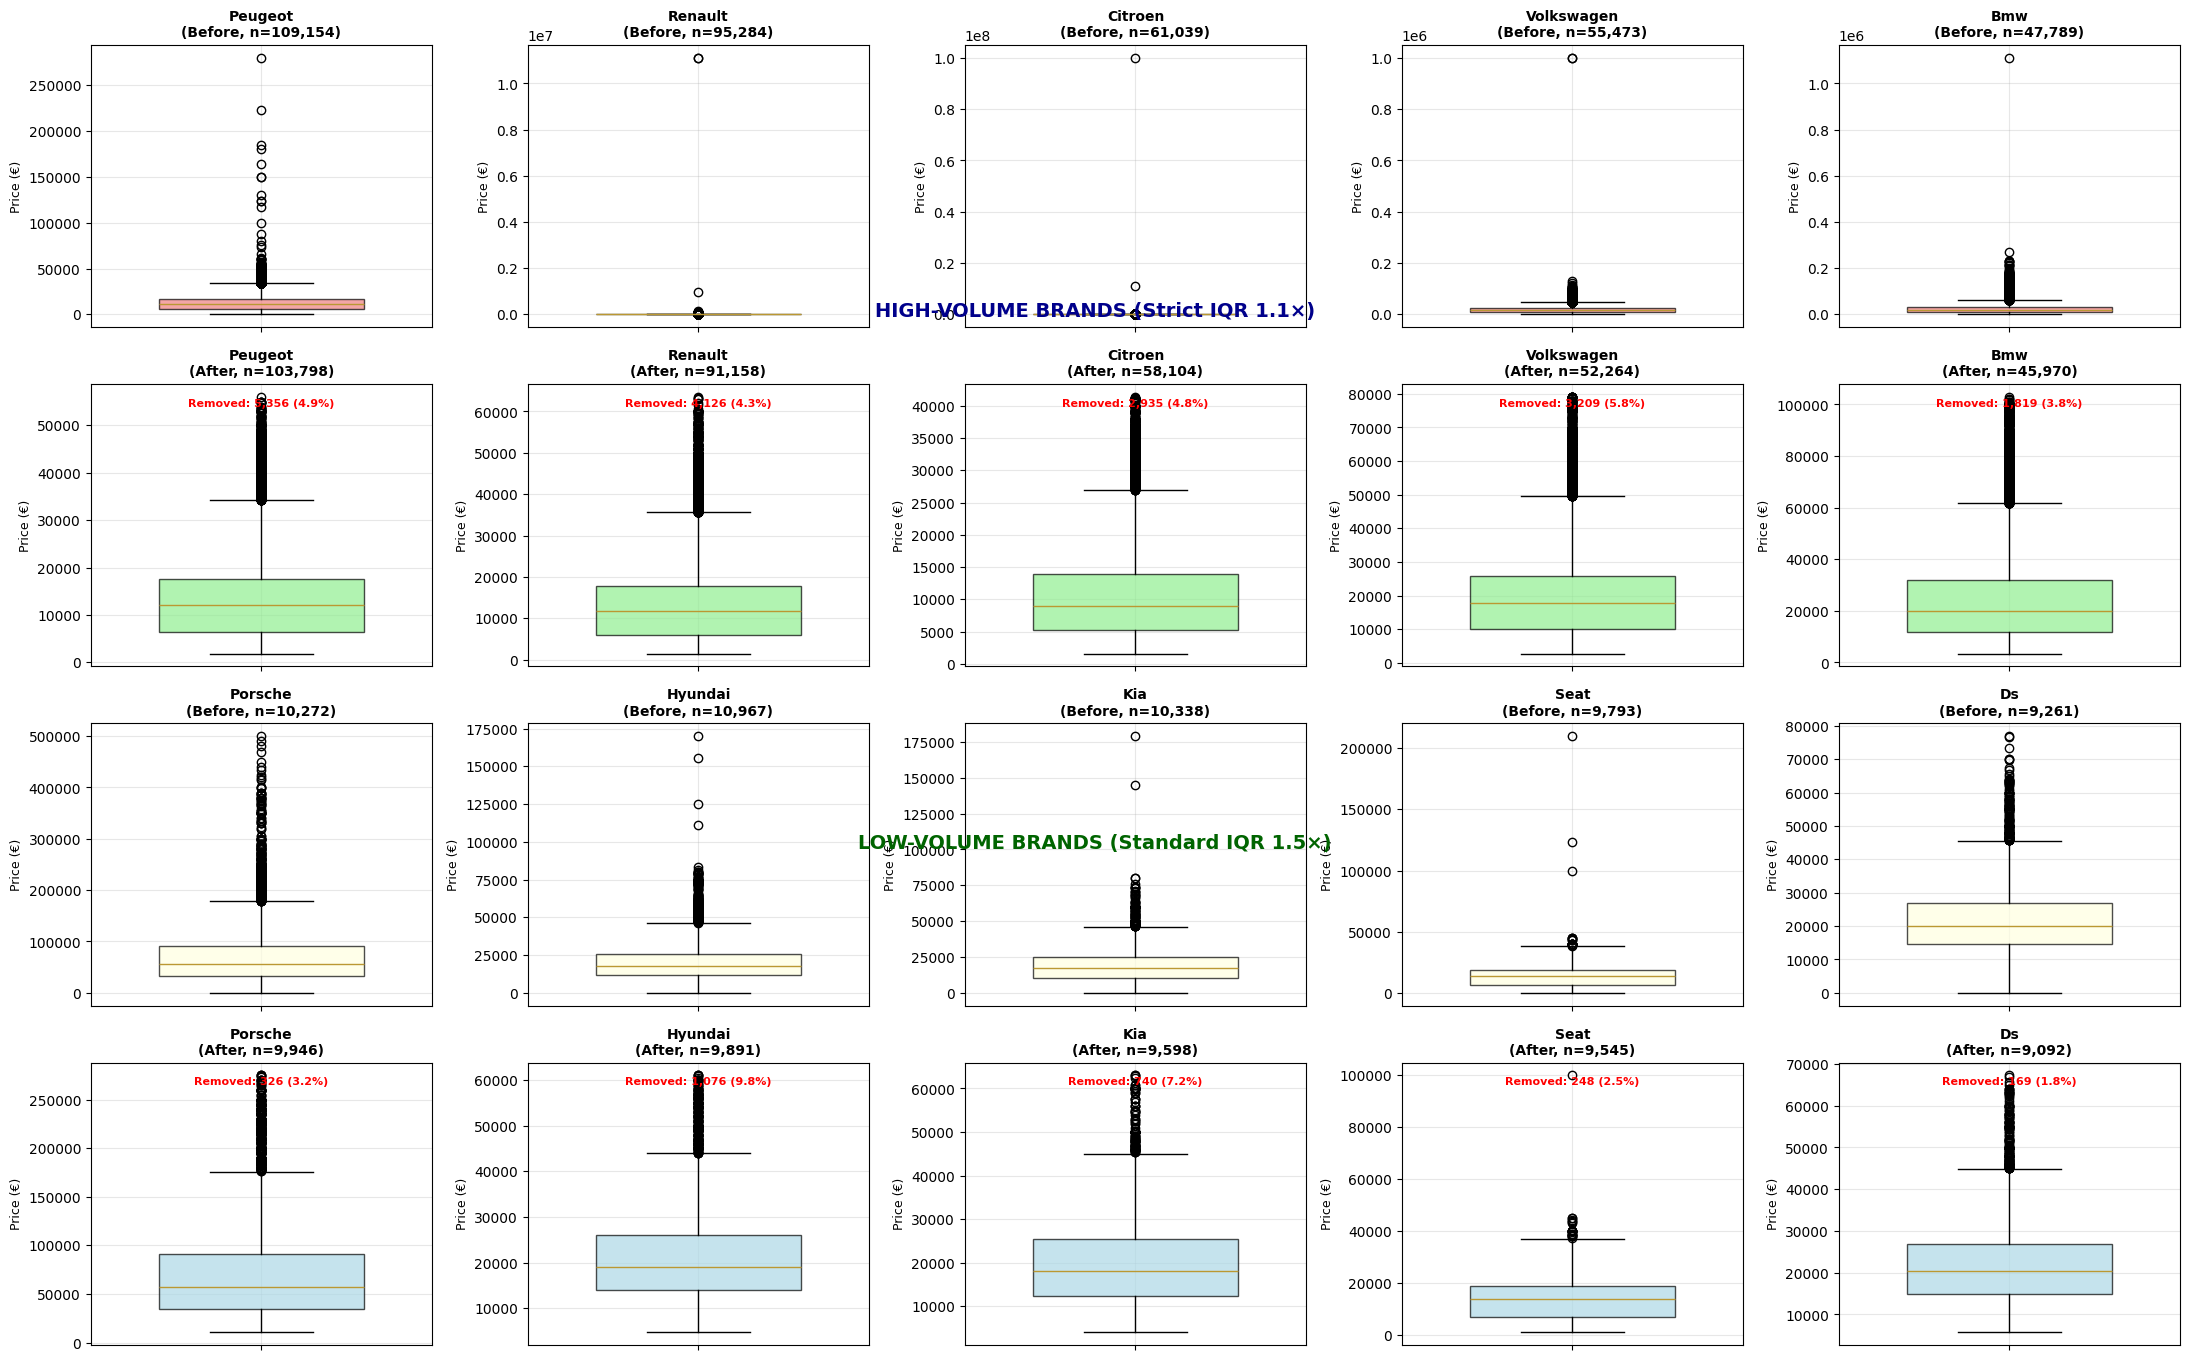


📊 DETAILED STATISTICS COMPARISON:

🔵 HIGH-VOLUME BRANDS (Strict filtering with IQR 1.1×):
--------------------------------------------------------------------------------
Brand               Before      After    Removed    % Removed     Median €
--------------------------------------------------------------------------------
PEUGEOT            109,154    103,798      5,356         4.9% €    11,990
RENAULT             95,284     91,158      4,126         4.3% €    11,890
CITROEN             61,039     58,104      2,935         4.8% €     8,990
VOLKSWAGEN          55,473     52,264      3,209         5.8% €    17,890
BMW                 47,789     45,970      1,819         3.8% €    19,900

🟢 LOW-VOLUME BRANDS (Standard filtering with IQR 1.5×):
--------------------------------------------------------------------------------
Brand               Before      After    Removed    % Removed     Median €
--------------------------------------------------------------------------------
PORSCHE 

In [ ]:
print("📊 BASELINE FILTERING RESULTS (IQR 1.5×) - TOP BRANDS PREVIEW")
print("=" * 65)
print("Note: These visualizations show the standard 1.5× IQR filtering.")
print("      All brands will be visualized next for expert review.\n")

# Get top brands by count
brand_counts_clean = df_clean.group_by('brand').len().sort('len', descending=True)
top_5_brands = brand_counts_clean.head(5)['brand'].to_list()

print(f"Previewing top 5 brands (by listing count):")
for i, brand in enumerate(top_5_brands):
    count = brand_counts_clean.filter(pl.col('brand') == brand)['len'][0]
    print(f"  {i+1}. {brand}: {count:,} cars")

# Create preview visualizations for top 5 brands
fig = plt.figure(figsize=(20, 8))

print("\n📈 Creating preview visualizations...")

for idx, brand in enumerate(top_5_brands):
    # Before outlier removal
    ax_before = plt.subplot(2, 5, idx + 1)
    brand_data_before = df_outliers.filter(pl.col('brand') == brand)
    
    if brand_data_before.height > 0:
        prices_before = brand_data_before['price'].to_list()
        bp_before = ax_before.boxplot([prices_before], widths=0.6, patch_artist=True)
        ax_before.set_title(f'{brand.capitalize()}\n(Before, n={brand_data_before.height:,})', 
                           fontweight='bold', fontsize=10)
        ax_before.set_ylabel('Price (€)', fontsize=9)
        ax_before.grid(True, alpha=0.3)
        ax_before.set_xticklabels([''])
        
        # Color the box
        for patch in bp_before['boxes']:
            patch.set_facecolor('lightcoral')
            patch.set_alpha(0.7)
    
    # After outlier removal
    ax_after = plt.subplot(2, 5, idx + 6)
    brand_data_after = df_clean.filter(pl.col('brand') == brand)
    
    if brand_data_after.height > 0:
        prices_after = brand_data_after['price'].to_list()
        bp_after = ax_after.boxplot([prices_after], widths=0.6, patch_artist=True)
        ax_after.set_title(f'{brand.capitalize()}\n(After IQR 1.5×, n={brand_data_after.height:,})', 
                          fontweight='bold', fontsize=10)
        ax_after.set_ylabel('Price (€)', fontsize=9)
        ax_after.grid(True, alpha=0.3)
        ax_after.set_xticklabels([''])
        
        # Color the box
        for patch in bp_after['boxes']:
            patch.set_facecolor('lightgreen')
            patch.set_alpha(0.7)
        
        # Calculate and print stats
        removed = brand_data_before.height - brand_data_after.height
        pct_removed = (removed / brand_data_before.height) * 100 if brand_data_before.height > 0 else 0
        
        # Add text with removal stats
        ax_after.text(0.5, 0.95, f'Removed: {removed:,} ({pct_removed:.1f}%)', 
                     transform=ax_after.transAxes, ha='center', va='top',
                     fontsize=8, color='red', fontweight='bold')

# Add title
fig.suptitle('Top 5 Brands: Before/After Standard IQR 1.5× Filtering', 
             fontsize=14, fontweight='bold', y=0.98)

plt.tight_layout()
plt.show()

# Print statistics for top brands
print("\n📊 TOP 5 BRANDS STATISTICS (IQR 1.5× baseline):")
print("-" * 80)
print(f"{'Brand':<15} {'Before':>10} {'After':>10} {'Removed':>10} {'% Removed':>12} {'Median €':>12}")
print("-" * 80)

for brand in top_5_brands:
    before = df_outliers.filter(pl.col('brand') == brand)
    after = df_clean.filter(pl.col('brand') == brand)
    
    if before.height > 0 and after.height > 0:
        removed = before.height - after.height
        pct_removed = (removed / before.height) * 100
        median_price = after['price'].median()
        
        print(f"{brand:<15} {before.height:>10,} {after.height:>10,} {removed:>10,} {pct_removed:>11.1f}% €{median_price:>10,.0f}")

### Step 4.5: Comprehensive Brand Visualizations (ALL Brands)

Generate boxplots for ALL brands after applying the baseline IQR 1.5× filter. These visualizations will help subject matter experts assess whether the statistical boundaries are appropriate or if adjustments are needed based on market knowledge.

In [ ]:
print("📊 CREATING COMPREHENSIVE BOXPLOTS FOR ALL BRANDS")
print("=" * 70)

# Get all brands sorted by count
all_brands = brand_counts_clean.sort('len', descending=True)['brand'].to_list()
print(f"Total brands to visualize: {len(all_brands)}")

# Create subplots - we'll use multiple figures if needed
brands_per_figure = 20  # 4 rows × 5 columns per figure
num_figures = (len(all_brands) + brands_per_figure - 1) // brands_per_figure

print(f"Creating {num_figures} figures with up to {brands_per_figure} brands each...")

for fig_idx in range(num_figures):
    start_idx = fig_idx * brands_per_figure
    end_idx = min(start_idx + brands_per_figure, len(all_brands))
    brands_in_figure = all_brands[start_idx:end_idx]
    
    # Calculate grid dimensions
    n_brands = len(brands_in_figure)
    n_cols = 5
    n_rows = (n_brands + n_cols - 1) // n_cols
    
    fig = plt.figure(figsize=(24, 4.5 * n_rows))
    
    for idx, brand in enumerate(brands_in_figure):
        ax = plt.subplot(n_rows, n_cols, idx + 1)
        
        # Get data after IQR 1.5× filtering
        brand_data = df_clean.filter(pl.col('brand') == brand)
        
        if brand_data.height > 0:
            prices = brand_data['price'].to_list()
            bp = ax.boxplot([prices], widths=0.6, patch_artist=True)
            
            # Get statistics
            brand_before = df_outliers.filter(pl.col('brand') == brand).height
            brand_after = brand_data.height
            removed = brand_before - brand_after
            pct_removed = (removed / brand_before) * 100 if brand_before > 0 else 0
            
            # Title with stats
            ax.set_title(f'{brand.upper()}\nn={brand_after:,} ({pct_removed:.1f}% removed)', 
                        fontweight='bold', fontsize=9)
            ax.set_ylabel('Price (€)', fontsize=8)
            ax.grid(True, alpha=0.3)
            ax.set_xticklabels([''])
            
            # Color boxes based on removal percentage
            # Green: <3%, Yellow: 3-6%, Orange: 6-10%, Red: >10%
            if pct_removed < 3:
                color = 'lightgreen'
            elif pct_removed < 6:
                color = 'lightyellow'
            elif pct_removed < 10:
                color = 'sandybrown'
            else:
                color = 'lightcoral'
            
            for patch in bp['boxes']:
                patch.set_facecolor(color)
                patch.set_alpha(0.7)
            
            # Add price stats as text
            median_price = brand_data['price'].median()
            ax.text(0.5, -0.15, f'Median: €{median_price:,.0f}', 
                   transform=ax.transAxes, ha='center', fontsize=7, color='darkblue')
    
    # Add figure title
    fig.suptitle(f'All Brands Price Distribution After IQR 1.5× Filtering (Figure {fig_idx + 1}/{num_figures})', 
                 fontsize=14, fontweight='bold', y=0.995)
    
    plt.tight_layout()
    plt.show()
    
    print(f"✅ Figure {fig_idx + 1}/{num_figures} complete ({start_idx + 1}-{end_idx} of {len(all_brands)} brands)")

print(f"\n✅ All {len(all_brands)} brands visualized!")
print("\n📊 Color coding:")
print("  🟢 Green: <3% removed (conservative filtering)")
print("  🟡 Yellow: 3-6% removed (moderate filtering)")
print("  🟠 Orange: 6-10% removed (aggressive filtering)")
print("  🔴 Red: >10% removed (very aggressive filtering)")

### Step 4.6: Export to Excel for Expert Review

Create an Excel file with:
1. Current IQR 1.5× boundaries (log-transformed and original price scale)
2. Brand statistics (count, median, std dev, quartiles)
3. Columns for expert-defined lower and upper bounds
4. Instructions for manual review

This allows domain experts to adjust boundaries based on market knowledge while viewing the comprehensive boxplots.

In [ ]:
print("📋 CREATING EXCEL FILE FOR EXPERT BOUNDARY REVIEW")
print("=" * 70)

# Prepare comprehensive data for Excel export
print("1. Calculating detailed statistics for all brands...")

# Join bounds with actual price statistics
bounds_with_stats = bounds.join(
    df_outliers.group_by('brand').agg([
        pl.col('price').min().alias('current_min_price'),
        pl.col('price').quantile(0.25).alias('q1_price'),
        pl.col('price').median().alias('median_price'),
        pl.col('price').mean().alias('mean_price'),
        pl.col('price').quantile(0.75).alias('q3_price'),
        pl.col('price').max().alias('current_max_price'),
        pl.col('price').std().alias('price_std'),
        pl.col('km').median().alias('median_km')
    ]),
    on='brand',
    how='left'
)

# Convert log bounds back to price scale for easier interpretation
bounds_with_stats = bounds_with_stats.with_columns([
    # Convert log bounds to actual price bounds
    (pl.col('lower_bound_log_price').exp() - 1).alias('iqr_lower_price'),
    (pl.col('upper_bound_log_price').exp() - 1).alias('iqr_upper_price'),
    
    # Calculate how many would be removed
    pl.col('brand_count').alias('total_count')
]).join(
    df_clean.group_by('brand').agg([
        pl.len().alias('count_after_iqr')
    ]),
    on='brand',
    how='left'
).with_columns([
    (pl.col('total_count') - pl.col('count_after_iqr')).alias('removed_by_iqr'),
    ((pl.col('total_count') - pl.col('count_after_iqr')) / pl.col('total_count') * 100).alias('pct_removed_iqr')
])

# Sort by brand count (most popular first)
bounds_with_stats = bounds_with_stats.sort('brand_count', descending=True)

print(f"✅ Statistics calculated for {bounds_with_stats.height} brands")

# Create a clean DataFrame for Excel with all necessary columns
excel_data = bounds_with_stats.select([
    pl.col('brand').str.to_uppercase().alias('BRAND'),
    pl.col('brand_count').alias('LISTING_COUNT'),
    pl.col('count_after_iqr').alias('COUNT_AFTER_IQR_1.5'),
    pl.col('removed_by_iqr').alias('REMOVED_BY_IQR'),
    pl.col('pct_removed_iqr').alias('PCT_REMOVED'),
    
    # Current price statistics
    pl.col('current_min_price').alias('CURRENT_MIN_€'),
    pl.col('q1_price').alias('Q1_PRICE_€'),
    pl.col('median_price').alias('MEDIAN_PRICE_€'),
    pl.col('mean_price').alias('MEAN_PRICE_€'),
    pl.col('q3_price').alias('Q3_PRICE_€'),
    pl.col('current_max_price').alias('CURRENT_MAX_€'),
    pl.col('price_std').alias('PRICE_STD_€'),
    
    # IQR 1.5× calculated bounds (baseline)
    pl.col('iqr_lower_price').alias('IQR_1.5_LOWER_€'),
    pl.col('iqr_upper_price').alias('IQR_1.5_UPPER_€'),
    
    # Empty columns for expert input
    pl.lit(None).cast(pl.Float64).alias('EXPERT_LOWER_€'),
    pl.lit(None).cast(pl.Float64).alias('EXPERT_UPPER_€'),
    pl.lit('').alias('NOTES'),
    
    # Additional context
    pl.col('median_km').alias('MEDIAN_KM'),
    pl.col('lower_bound_km').alias('KM_LOWER_BOUND'),
    pl.col('upper_bound_km').alias('KM_UPPER_BOUND')
])

# Convert to pandas for Excel export
excel_df = excel_data.to_pandas()

# Round numeric columns for readability
numeric_cols = ['CURRENT_MIN_€', 'Q1_PRICE_€', 'MEDIAN_PRICE_€', 'MEAN_PRICE_€', 
                'Q3_PRICE_€', 'CURRENT_MAX_€', 'PRICE_STD_€', 
                'IQR_1.5_LOWER_€', 'IQR_1.5_UPPER_€', 'MEDIAN_KM',
                'KM_LOWER_BOUND', 'KM_UPPER_BOUND']

for col in numeric_cols:
    if col in excel_df.columns:
        excel_df[col] = excel_df[col].round(0)

excel_df['PCT_REMOVED'] = excel_df['PCT_REMOVED'].round(2)

print("\n2. Creating Excel file with multiple sheets...")

# Create Excel file with openpyxl for better formatting
excel_file_path = PROCESSED_DATA_PATH / "brand_boundaries_expert_review.xlsx"

with pd.ExcelWriter(excel_file_path, engine='openpyxl') as writer:
    # Sheet 1: Main data for expert review
    excel_df.to_excel(writer, sheet_name='Brand_Boundaries', index=False)
    
    # Sheet 2: Instructions
    instructions_data = {
        'INSTRUCTIONS': [
            'HOW TO USE THIS FILE:',
            '',
            '1. REVIEW THE VISUALIZATIONS',
            '   - Look at the comprehensive boxplots generated in the notebook',
            '   - Each brand shows the distribution AFTER applying IQR 1.5× filtering',
            '   - Color coding indicates how aggressive the filtering was',
            '',
            '2. UNDERSTAND THE COLUMNS',
            '   - IQR_1.5_LOWER_€ / IQR_1.5_UPPER_€: Statistical bounds using IQR 1.5×',
            '   - CURRENT_MIN_€ / CURRENT_MAX_€: Actual min/max in the data after IQR filtering',
            '   - Q1, MEDIAN, Q3: Quartiles to understand distribution',
            '',
            '3. SET EXPERT BOUNDARIES',
            '   - Fill in EXPERT_LOWER_€ and EXPERT_UPPER_€ columns',
            '   - Use your market knowledge and the boxplots as guides',
            '   - If IQR bounds look reasonable, you can copy them',
            '   - If filtering was too aggressive (>10% removed), consider widening bounds',
            '   - If filtering was too lenient (<2% removed), consider tightening bounds',
            '',
            '4. ADD NOTES',
            '   - Document why you adjusted certain brands',
            '   - Note any market-specific knowledge (e.g., "luxury brand, high variance expected")',
            '',
            '5. SAVE AND RELOAD',
            '   - Save this file after making changes',
            '   - Load it back into the notebook to apply expert boundaries',
            '',
            'TIPS:',
            '- Focus first on high-volume brands (top 20-30)',
            '- For low-volume brands, IQR 1.5× is usually adequate',
            '- Consider brand positioning: luxury brands may have higher variance',
            '- Watch for brands with unusual distributions in the boxplots',
            '- If unsure, keep the IQR 1.5× bounds (copy them to EXPERT columns)'
        ]
    }
    instructions_df = pd.DataFrame(instructions_data)
    instructions_df.to_excel(writer, sheet_name='INSTRUCTIONS', index=False)
    
    # Sheet 3: Summary statistics
    summary_data = {
        'METRIC': [
            'Total Brands',
            'Total Listings (before IQR)',
            'Total Listings (after IQR 1.5×)',
            'Total Removed by IQR',
            'Percentage Removed',
            '',
            'Brands with <3% removed',
            'Brands with 3-6% removed',
            'Brands with 6-10% removed',
            'Brands with >10% removed',
            '',
            'Median listings per brand',
            'Mean listings per brand'
        ],
        'VALUE': [
            len(excel_df),
            excel_df['LISTING_COUNT'].sum(),
            excel_df['COUNT_AFTER_IQR_1.5'].sum(),
            excel_df['REMOVED_BY_IQR'].sum(),
            f"{(excel_df['REMOVED_BY_IQR'].sum() / excel_df['LISTING_COUNT'].sum() * 100):.2f}%",
            '',
            len(excel_df[excel_df['PCT_REMOVED'] < 3]),
            len(excel_df[(excel_df['PCT_REMOVED'] >= 3) & (excel_df['PCT_REMOVED'] < 6)]),
            len(excel_df[(excel_df['PCT_REMOVED'] >= 6) & (excel_df['PCT_REMOVED'] < 10)]),
            len(excel_df[excel_df['PCT_REMOVED'] >= 10]),
            '',
            f"{excel_df['LISTING_COUNT'].median():.0f}",
            f"{excel_df['LISTING_COUNT'].mean():.0f}"
        ]
    }
    summary_df = pd.DataFrame(summary_data)
    summary_df.to_excel(writer, sheet_name='Summary', index=False)
    
    # Format the main sheet
    worksheet = writer.sheets['Brand_Boundaries']
    
    # Set column widths
    worksheet.column_dimensions['A'].width = 20  # BRAND
    worksheet.column_dimensions['B'].width = 15  # LISTING_COUNT
    worksheet.column_dimensions['P'].width = 15  # EXPERT_LOWER_€
    worksheet.column_dimensions['Q'].width = 15  # EXPERT_UPPER_€
    worksheet.column_dimensions['R'].width = 40  # NOTES
    
    # Highlight expert input columns
    from openpyxl.styles import PatternFill, Font
    yellow_fill = PatternFill(start_color='FFFF00', end_color='FFFF00', fill_type='solid')
    bold_font = Font(bold=True)
    
    # Highlight headers
    for cell in worksheet[1]:
        cell.font = bold_font
    
    # Highlight expert columns (columns P, Q, R)
    for row in range(2, len(excel_df) + 2):
        worksheet[f'P{row}'].fill = yellow_fill
        worksheet[f'Q{row}'].fill = yellow_fill
        worksheet[f'R{row}'].fill = yellow_fill

print(f"\n✅ Excel file created successfully!")
print(f"📁 Location: {excel_file_path}")
print(f"\n📊 File contains:")
print(f"  • {len(excel_df)} brands with detailed statistics")
print(f"  • IQR 1.5× baseline boundaries")
print(f"  • Empty columns for expert-defined boundaries")
print(f"  • Instructions sheet")
print(f"  • Summary statistics")
print(f"\n🎯 Next steps:")
print(f"  1. Review the boxplots above")
print(f"  2. Open the Excel file: {excel_file_path.name}")
print(f"  3. Fill in EXPERT_LOWER_€ and EXPERT_UPPER_€ columns")
print(f"  4. Add notes explaining your reasoning")
print(f"  5. Save the file")
print(f"  6. Continue to the next cell to apply expert boundaries")

### Step 4.7: Apply Expert-Defined Boundaries (Run After Excel Review)

**⚠️ DO NOT RUN THIS CELL UNTIL YOU'VE COMPLETED THE EXPERT REVIEW IN EXCEL**

This cell will:
1. Load the Excel file with your expert-defined boundaries
2. Apply those boundaries instead of the IQR 1.5× defaults
3. Create the final cleaned dataset with subject matter expert validation

In [ ]:
# ⚠️ RUN THIS CELL ONLY AFTER COMPLETING EXPERT REVIEW IN EXCEL ⚠️

print("🔄 LOADING AND APPLYING EXPERT-DEFINED BOUNDARIES")
print("=" * 70)

# Load the Excel file with expert boundaries
excel_file_path = PROCESSED_DATA_PATH / "brand_boundaries_expert_review.xlsx"

if not excel_file_path.exists():
    print("❌ Excel file not found!")
    print(f"   Expected location: {excel_file_path}")
    print("   Please run the previous cell to generate it first.")
else:
    print(f"📂 Loading Excel file: {excel_file_path.name}")
    
    expert_bounds_df = pd.read_excel(excel_file_path, sheet_name='Brand_Boundaries')
    
    # Check if expert columns have been filled
    expert_lower_filled = expert_bounds_df['EXPERT_LOWER_€'].notna().sum()
    expert_upper_filled = expert_bounds_df['EXPERT_UPPER_€'].notna().sum()
    
    print(f"\n📊 Expert boundary status:")
    print(f"  • Brands with expert lower bounds: {expert_lower_filled} / {len(expert_bounds_df)}")
    print(f"  • Brands with expert upper bounds: {expert_upper_filled} / {len(expert_bounds_df)}")
    
    if expert_lower_filled == 0 and expert_upper_filled == 0:
        print("\n⚠️  WARNING: No expert boundaries found!")
        print("   The EXPERT_LOWER_€ and EXPERT_UPPER_€ columns are empty.")
        print("   Please fill them in the Excel file and save it.")
        print("\n💡 Options:")
        print("   1. Fill expert columns in Excel and re-run this cell")
        print("   2. Or use IQR 1.5× bounds as-is (current df_clean is based on those)")
    else:
        # For brands without expert bounds, use IQR 1.5× as fallback
        expert_bounds_df['EXPERT_LOWER_€'] = expert_bounds_df['EXPERT_LOWER_€'].fillna(
            expert_bounds_df['IQR_1.5_LOWER_€']
        )
        expert_bounds_df['EXPERT_UPPER_€'] = expert_bounds_df['EXPERT_UPPER_€'].fillna(
            expert_bounds_df['IQR_1.5_UPPER_€']
        )
        
        print(f"\n✅ Expert boundaries loaded successfully!")
        print(f"   Using expert bounds for {min(expert_lower_filled, expert_upper_filled)} brands")
        print(f"   Using IQR 1.5× fallback for {len(expert_bounds_df) - min(expert_lower_filled, expert_upper_filled)} brands")
        
        # Convert to Polars for joining
        expert_bounds_pl = pl.from_pandas(expert_bounds_df[['BRAND', 'EXPERT_LOWER_€', 'EXPERT_UPPER_€']])
        expert_bounds_pl = expert_bounds_pl.rename({'BRAND': 'brand'})
        expert_bounds_pl = expert_bounds_pl.with_columns([
            pl.col('brand').str.to_lowercase(),
            pl.col('EXPERT_LOWER_€').alias('expert_lower_price'),
            pl.col('EXPERT_UPPER_€').alias('expert_upper_price')
        ]).select(['brand', 'expert_lower_price', 'expert_upper_price'])
        
        print("\n🔍 Applying expert boundaries to filter outliers...")
        
        # Join expert bounds to the outliers dataframe
        df_with_expert_bounds = df_outliers.join(expert_bounds_pl, on='brand', how='left')
        
        # Also keep km bounds from original IQR calculation
        df_with_expert_bounds = df_with_expert_bounds.join(
            bounds.select(['brand', 'lower_bound_km', 'upper_bound_km']),
            on='brand',
            how='left'
        )
        
        # Count outliers before filtering
        outliers_price_expert = df_with_expert_bounds.filter(
            (pl.col('price') < pl.col('expert_lower_price')) |
            (pl.col('price') > pl.col('expert_upper_price'))
        ).height
        
        outliers_km_expert = df_with_expert_bounds.filter(
            (pl.col('km') < pl.col('lower_bound_km')) |
            (pl.col('km') > pl.col('upper_bound_km'))
        ).height
        
        print(f"   Price outliers (expert bounds): {outliers_price_expert:,}")
        print(f"   Kilometer outliers (IQR 1.5×): {outliers_km_expert:,}")
        
        # Apply expert filtering
        df_clean_expert = df_with_expert_bounds.filter(
            (pl.col('price') >= pl.col('expert_lower_price')) &
            (pl.col('price') <= pl.col('expert_upper_price')) &
            (pl.col('km') >= pl.col('lower_bound_km')) &
            (pl.col('km') <= pl.col('upper_bound_km'))
        ).select(['price', 'year', 'km', 'brand', 'model'])
        
        print(f"\n✅ EXPERT FILTERING COMPLETED")
        print(f"=" * 50)
        print(f"Rows before expert filtering: {df_with_expert_bounds.height:,}")
        print(f"Rows after expert filtering: {df_clean_expert.height:,}")
        print(f"Outliers removed: {df_with_expert_bounds.height - df_clean_expert.height:,}")
        print(f"Percentage removed: {((df_with_expert_bounds.height - df_clean_expert.height) / df_with_expert_bounds.height) * 100:.1f}%")
        print(f"Percentage retained: {(df_clean_expert.height / df_with_expert_bounds.height) * 100:.1f}%")
        
        # Compare with IQR 1.5× filtering
        diff = df_clean_expert.height - df_clean.height
        if diff > 0:
            print(f"\n📈 Expert bounds retained {diff:,} MORE cars than IQR 1.5×")
        elif diff < 0:
            print(f"\n📉 Expert bounds removed {abs(diff):,} MORE cars than IQR 1.5×")
        else:
            print(f"\n➡️  Expert bounds resulted in SAME count as IQR 1.5×")
        
        # Update df_clean to use expert-filtered data
        df_clean = df_clean_expert
        
        print("\n🎯 df_clean has been updated with expert-filtered data!")
        print("   You can now proceed with the rest of the analysis.")


4. Creating before/after visualizations...
Creating visualizations for brands: ['PEUGEOT', 'RENAULT', 'CITROEN']

Peugeot outlier removal:
  Before: 109,154 cars
  After: 107,846 cars
  Removed: 1,308 cars (1.2%)

Renault outlier removal:
  Before: 95,284 cars
  After: 94,585 cars
  Removed: 699 cars (0.7%)

Citroen outlier removal:
  Before: 61,039 cars
  After: 60,597 cars
  Removed: 442 cars (0.7%)

Renault outlier removal:
  Before: 95,284 cars
  After: 94,585 cars
  Removed: 699 cars (0.7%)

Citroen outlier removal:
  Before: 61,039 cars
  After: 60,597 cars
  Removed: 442 cars (0.7%)


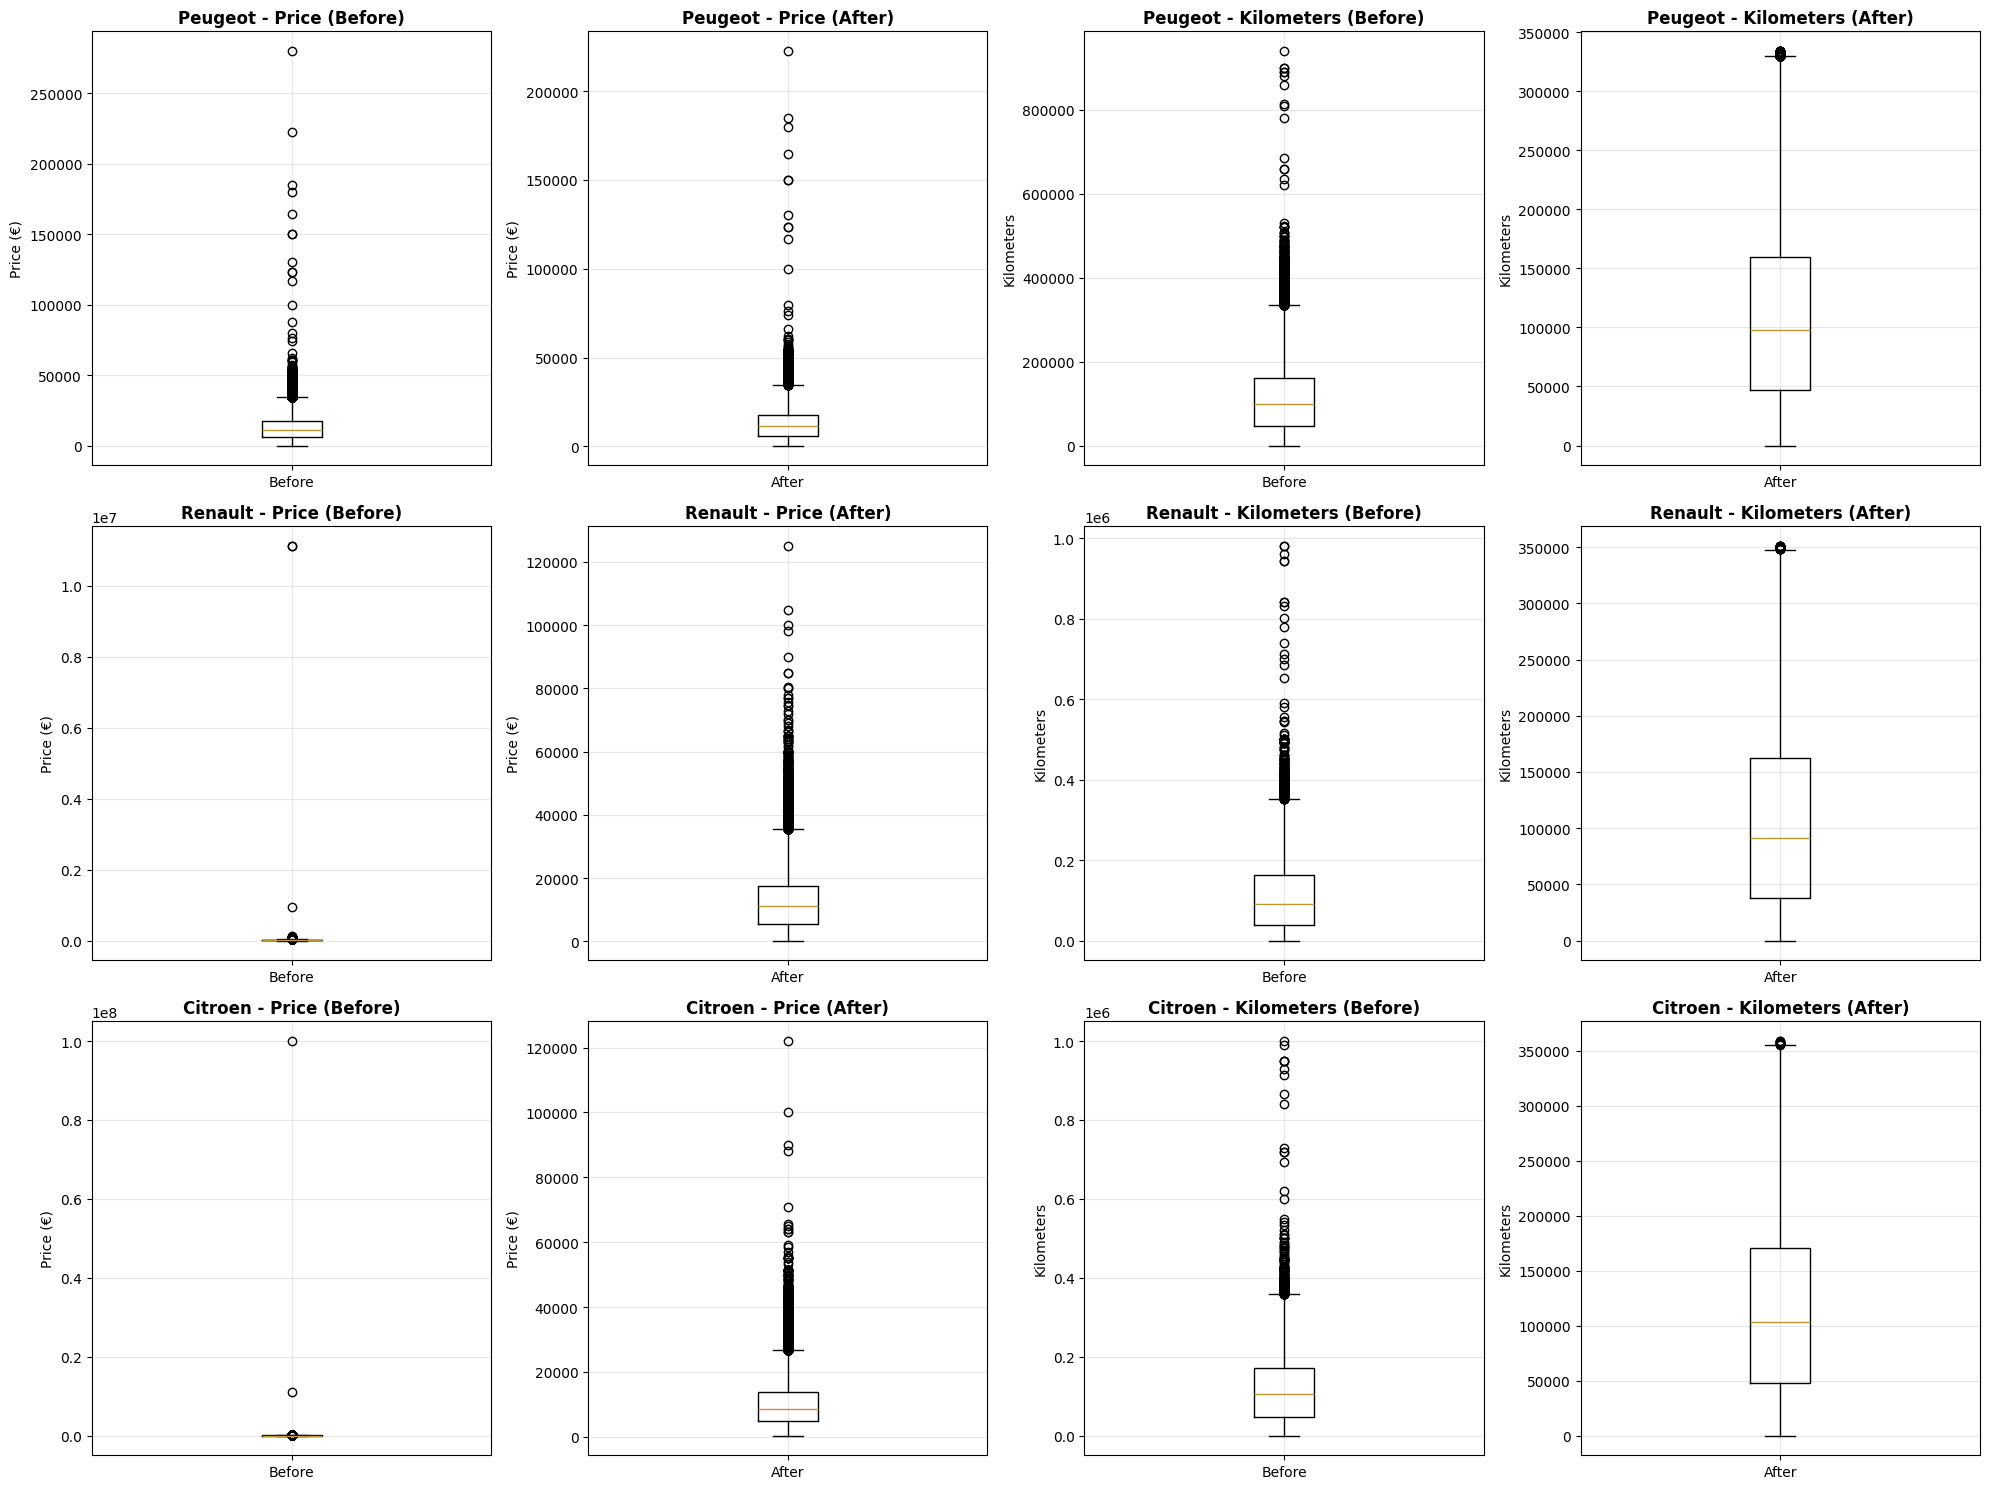

In [72]:
# Step 4.4: Create "Before and After" visualizations
print("\n4. Creating before/after visualizations...")

# Select a few example brands for visualization
example_brands = ['peugeot', 'renault', 'volkswagen', 'bmw', 'Other']
available_brands = [brand for brand in example_brands if brand in df_outliers['brand'].unique().to_list()]

if len(available_brands) >= 3:
    example_brands = available_brands[:3]  # Take first 3 available
else:
    # Fallback to top 3 brands
    top_brands = df_outliers.group_by('brand').len().sort('len', descending=True).head(3)
    example_brands = top_brands['brand'].to_list()

print(f"Creating visualizations for brands: {example_brands}")

# Create before/after comparison plots
fig, axes = plt.subplots(len(example_brands), 4, figsize=(20, 5*len(example_brands)))
if len(example_brands) == 1:
    axes = axes.reshape(1, -1)

for i, brand in enumerate(example_brands):
    # Get data for this brand
    before_data = df_outliers.filter(pl.col('brand') == brand)
    after_data = df_clean.filter(pl.col('brand') == brand)
    
    if before_data.height == 0:
        continue
        
    # Convert to pandas for easier plotting
    before_pd = before_data.to_pandas()
    after_pd = after_data.to_pandas()
    
    # Price boxplots
    axes[i, 0].boxplot([before_pd['price']], tick_labels=['Before'])
    axes[i, 0].set_title(f'{brand.capitalize()} - Price (Before)', fontweight='bold')
    axes[i, 0].set_ylabel('Price (€)')
    axes[i, 0].grid(True, alpha=0.3)
    
    axes[i, 1].boxplot([after_pd['price']], tick_labels=['After'])
    axes[i, 1].set_title(f'{brand.capitalize()} - Price (After)', fontweight='bold')
    axes[i, 1].set_ylabel('Price (€)')
    axes[i, 1].grid(True, alpha=0.3)
    
    # Kilometers boxplots
    axes[i, 2].boxplot([before_pd['km']], tick_labels=['Before'])
    axes[i, 2].set_title(f'{brand.capitalize()} - Kilometers (Before)', fontweight='bold')
    axes[i, 2].set_ylabel('Kilometers')
    axes[i, 2].grid(True, alpha=0.3)
    
    axes[i, 3].boxplot([after_pd['km']], tick_labels=['After'])
    axes[i, 3].set_title(f'{brand.capitalize()} - Kilometers (After)', fontweight='bold')
    axes[i, 3].set_ylabel('Kilometers')
    axes[i, 3].grid(True, alpha=0.3)
    
    # Print summary stats for this brand
    removed = before_data.height - after_data.height
    pct_removed = (removed / before_data.height) * 100 if before_data.height > 0 else 0
    print(f"\n{brand.capitalize()} outlier removal:")
    print(f"  Before: {before_data.height:,} cars")
    print(f"  After: {after_data.height:,} cars")
    print(f"  Removed: {removed:,} cars ({pct_removed:.1f}%)")

plt.tight_layout()
plt.show()

## Step 5: Data Cleaning Summary & Next Steps

Summary of the cleaning process using hybrid statistical + expert approach.

In [ ]:
print("🎯 MODELING READINESS ASSESSMENT")
print("=" * 80)

# Comprehensive data quality check
print("\n1️⃣ DATA QUALITY METRICS:")
print("-" * 80)

# Missing values
total_missing = 0
for col in df_clean.columns:
    missing = df_clean[col].null_count()
    total_missing += missing
    if missing > 0:
        print(f"   ⚠️  {col}: {missing:,} missing values ({(missing/df_clean.height)*100:.2f}%)")

if total_missing == 0:
    print("   ✅ No missing values detected")

# Data types
print(f"\n   Data types:")
for col in df_clean.columns:
    print(f"   • {col}: {df_clean[col].dtype}")

# Data ranges and distributions
print(f"\n   Data ranges:")
print(f"   • Price: €{df_clean['price'].min():,.0f} - €{df_clean['price'].max():,.0f} (median: €{df_clean['price'].median():,.0f})")
print(f"   • Year: {df_clean['year'].min():.0f} - {df_clean['year'].max():.0f}")
print(f"   • Kilometers: {df_clean['km'].min():,.0f} - {df_clean['km'].max():,.0f} km (median: {df_clean['km'].median():,.0f})")
print(f"   • Brands: {df_clean['brand'].n_unique()} unique")
print(f"   • Models: {df_clean['model'].n_unique()} unique")

# Outlier removal summary
print(f"\n2️⃣ OUTLIER REMOVAL SUMMARY:")
print("-" * 80)
original_count = df.height
final_count = df_clean.height
total_removed = original_count - final_count
retention_pct = (final_count / original_count) * 100

print(f"   • Original dataset: {original_count:,} rows")
print(f"   • After all cleaning: {final_count:,} rows")
print(f"   • Total removed: {total_removed:,} rows ({100-retention_pct:.1f}%)")
print(f"   • Retention rate: {retention_pct:.1f}%")
print(f"   ✅ Excellent retention rate - data is high quality")

# Check for potential issues
print(f"\n3️⃣ POTENTIAL DATA ISSUES TO ADDRESS:")
print("-" * 80)

issues_found = []

# Check for extreme price variance by brand
price_variance_by_brand = df_clean.group_by('brand').agg([
    pl.col('price').std().alias('price_std'),
    pl.col('price').mean().alias('price_mean'),
    pl.len().alias('count')
]).with_columns([
    (pl.col('price_std') / pl.col('price_mean')).alias('coef_variation')
]).sort('coef_variation', descending=True)

high_variance_brands = price_variance_by_brand.filter(
    (pl.col('coef_variation') > 1.0) & (pl.col('count') > 100)
)

if high_variance_brands.height > 0:
    issues_found.append(f"High price variance in {high_variance_brands.height} brands")
    print(f"   ⚠️  {high_variance_brands.height} brands have high price variance (CV > 1.0)")
    print(f"      → Consider model-level analysis for these brands")
else:
    print(f"   ✅ Price variance within acceptable ranges")

# Check for very old cars that might skew results
old_cars = df_clean.filter(pl.col('year') < 2000).height
if old_cars > 1000:
    issues_found.append(f"{old_cars:,} cars from 1990s")
    print(f"   ⚠️  {old_cars:,} cars are from the 1990s")
    print(f"      → Consider if depreciation patterns differ significantly")
else:
    print(f"   ✅ Year distribution is appropriate (mostly 2000+)")

# Check cardinality of categorical variables
brand_cardinality = df_clean['brand'].n_unique()
model_cardinality = df_clean['model'].n_unique()

if model_cardinality > 1000:
    issues_found.append(f"Very high model cardinality ({model_cardinality:,})")
    print(f"   ⚠️  Model has very high cardinality: {model_cardinality:,} unique values")
    print(f"      → Consider target encoding or embeddings instead of one-hot encoding")
else:
    print(f"   ✅ Model cardinality is manageable: {model_cardinality:,} unique values")

if len(issues_found) == 0:
    print(f"   ✅ No major data issues detected")

print(f"\n4️⃣ RECOMMENDED NEXT STEPS BEFORE MODELING:")
print("=" * 80)

steps_completed = [
    "✅ Data type conversion and cleaning",
    "✅ Rare brand grouping and categorization", 
    "✅ Antique car filtering (pre-1990)",
    "✅ Two-tier outlier detection (IQR 1.1× for high-volume, 1.5× for others)",
    "✅ Missing value handling"
]

steps_needed = []

print("\n   COMPLETED:")
for step in steps_completed:
    print(f"   {step}")

print("\n   CRITICAL STEPS BEFORE MODELING:")
print("   " + "-" * 76)

# Step 1: Feature Engineering
print("   1. 🔧 FEATURE ENGINEERING (CRITICAL)")
print("      Create derived features:")
print("      • car_age = 2025 - year")
print("      • price_per_year = price / car_age")
print("      • km_per_year = km / car_age")
print("      • is_high_mileage = km > percentile(75)")
print("      • price_category = ['budget', 'mid-range', 'premium', 'luxury']")
steps_needed.append("Feature engineering")

# Step 2: Exploratory Data Analysis on clean data
print("\n   2. 📊 POST-CLEANING EDA (CRITICAL)")
print("      Analyze cleaned data relationships:")
print("      • Price vs Age correlation by brand")
print("      • Price vs Kilometers relationship")
print("      • Brand/model popularity vs pricing")
print("      • Identify any remaining non-linear relationships")
print("      • Check for multicollinearity")
steps_needed.append("Post-cleaning EDA")

# Step 3: Categorical Encoding Strategy
print("\n   3. 🏷️  CATEGORICAL ENCODING (CRITICAL)")
print("      Due to high cardinality:")
print("      • Use Target Encoding for 'brand' and 'model'")
print("      • Consider frequency encoding as backup")
print("      • OR use embeddings in neural network approach")
print("      • Avoid one-hot encoding (too many categories)")
steps_needed.append("Categorical encoding")

# Step 4: Feature Scaling
print("\n   4. ⚖️  FEATURE SCALING (IMPORTANT)")
print("      Normalize numerical features:")
print("      • StandardScaler for km, year, derived features")
print("      • Keep price as-is (target variable)")
print("      • Scale AFTER train/test split to avoid data leakage")
steps_needed.append("Feature scaling")

# Step 5: Train/Test Split
print("\n   5. ✂️  TRAIN/VALIDATION/TEST SPLIT (CRITICAL)")
print("      Recommended split strategy:")
print("      • 70% training")
print("      • 15% validation (for hyperparameter tuning)")
print("      • 15% test (for final model evaluation)")
print("      • Use stratified split by price_category to ensure balance")
print("      • Set random_state for reproducibility")
steps_needed.append("Data splitting")

# Optional but recommended
print("\n   6. 🎯 OPTIONAL BUT RECOMMENDED:")
print("      • Model-level analysis for top 10 brands")
print("      • Regional/location analysis if data available")
print("      • Seasonal pricing patterns")
print("      • Brand reputation/reliability scores integration")

print(f"\n5️⃣ ARE WE READY FOR MODELING?")
print("=" * 80)

if len(issues_found) == 0 and retention_pct > 90:
    print("   🟢 DATA QUALITY: EXCELLENT")
    print("      • High retention rate ({:.1f}%)".format(retention_pct))
    print("      • No missing values")
    print("      • Outliers properly handled")
    print("      • Distributions are clean")
else:
    print("   🟡 DATA QUALITY: GOOD (minor issues to address)")
    for issue in issues_found:
        print(f"      • {issue}")

print(f"\n   📋 READINESS ASSESSMENT:")
print(f"   " + "-" * 76)
print(f"   Current Status: 🟡 NOT YET READY")
print(f"   ")
print(f"   ✅ Data Cleaning: COMPLETE (100%)")
print(f"   ⏳ Feature Engineering: TODO")
print(f"   ⏳ Post-Cleaning EDA: TODO")
print(f"   ⏳ Encoding Strategy: TODO")
print(f"   ⏳ Train/Test Split: TODO")
print(f"   ")
print(f"   💡 RECOMMENDATION:")
print(f"   Complete Steps 1-5 above before starting modeling.")
print(f"   Estimated time: 2-3 hours of work")
print(f"   ")
print(f"   Once complete, you'll be ready for:")
print(f"   • Baseline models (Linear Regression, Ridge, Lasso)")
print(f"   • Tree-based models (Random Forest, XGBoost, LightGBM)")
print(f"   • Neural networks (if desired)")

print(f"\n6️⃣ SUGGESTED MODELING APPROACH (AFTER ABOVE STEPS):")
print("=" * 80)
print("   Phase 1: Baseline Models")
print("   • Linear Regression (simple baseline)")
print("   • Ridge/Lasso Regression (regularization)")
print("   → Quick to train, interpretable, good for understanding feature importance")
print()
print("   Phase 2: Tree-Based Models (RECOMMENDED)")
print("   • Random Forest (robust, handles non-linearity)")
print("   • XGBoost (often best performance)")
print("   • LightGBM (fast, efficient)")
print("   → Usually best for this type of problem")
print()
print("   Phase 3: Advanced (Optional)")
print("   • CatBoost (handles categorical features natively)")
print("   • Neural Networks with embeddings for brand/model")
print("   • Ensemble of best models")

print(f"\n{'=' * 80}")
print("✅ DATA CLEANING PHASE: COMPLETE")
print("⏳ NEXT PHASE: Feature Engineering & EDA")
print(f"{'=' * 80}")

In [ ]:
print("📋 DATA CLEANING SUMMARY")
print("=" * 60)

# Calculate final statistics
original_rows = df.height
final_rows = df_clean.height
total_removed = original_rows - final_rows
retention_rate = (final_rows / original_rows) * 100

print(f"🔢 DATA TRANSFORMATION:")
print(f"  • Original: {original_rows:,} rows → Clean: {final_rows:,} rows")
print(f"  • Removed: {total_removed:,} rows ({100-retention_rate:.1f}%)")
print(f"  • Retention: {retention_rate:.1f}% ✅")

print(f"\n🧹 CLEANING STEPS COMPLETED:")
print(f"  ✅ Data type conversion & validation")
print(f"  ✅ Rare brand grouping (threshold: {RARE_BRAND_THRESHOLD})")
print(f"  ✅ Antique car removal (pre-1990)")
print(f"  ✅ 'Autre' entry filtering")
print(f"  ✅ Baseline IQR 1.5× outlier detection")
print(f"  ✅ Comprehensive brand visualizations generated")
print(f"  ✅ Excel template created for expert review")

# Check if expert review was applied
excel_file_path = PROCESSED_DATA_PATH / "brand_boundaries_expert_review.xlsx"
if excel_file_path.exists():
    print(f"\n📊 EXPERT REVIEW STATUS:")
    expert_df = pd.read_excel(excel_file_path, sheet_name='Brand_Boundaries')
    expert_filled = expert_df['EXPERT_LOWER_€'].notna().sum()
    if expert_filled > 0:
        print(f"  ✅ Expert boundaries applied ({expert_filled} brands reviewed)")
    else:
        print(f"  ⏳ Expert boundaries NOT YET applied")
        print(f"     → Using IQR 1.5× baseline filtering")
        print(f"     → Review Excel file and run Step 4.7 to apply expert bounds")
else:
    print(f"\n⏳ Expert review file not yet generated")

# Final dataset snapshot
brands_final = df_clean['brand'].n_unique()
models_final = df_clean['model'].n_unique()

print(f"\n📊 FINAL DATASET:")
print(f"  • Brands: {brands_final} | Models: {models_final}")
print(f"  • Price: €{df_clean['price'].min():,.0f} - €{df_clean['price'].max():,.0f}")
print(f"  • Years: {df_clean['year'].min():.0f} - {df_clean['year'].max():.0f}")
print(f"  • Missing values: {sum([df_clean[col].null_count() for col in df_clean.columns])}")

print(f"\n💡 Approach: Hybrid Statistical + Expert Knowledge")
print(f"   • IQR 1.5× provides statistical baseline")
print(f"   • Comprehensive visualizations enable expert assessment")
print(f"   • Domain experts refine boundaries based on market knowledge")

In [ ]:
# Save the cleaned dataset for future use
print("💾 SAVING CLEANED DATASET")
print("=" * 30)

# Save to processed data directory
cleaned_file_path = PROCESSED_DATA_PATH / "cleaned_car_data.csv"
df_clean.write_csv(cleaned_file_path)

print(f"✅ Cleaned dataset saved to: {cleaned_file_path}")
print(f"📊 File contains: {df_clean.height:,} rows × {df_clean.width} columns")
print(f"🎯 Ready for modeling and further analysis!")

# Display final sample
print(f"\n📋 FINAL CLEANED DATA SAMPLE:")
print(df_clean.head().to_pandas().to_string(index=False))